This notebook tries to search for optimal fixed policies (e.g. constant mortality) that maximize the objective (i.e. expected net reward). Here I try [scikit-optimize](https://scikit-optimize.github.io/stable/index.html).

# Setup
---

In [2]:
# %pip install -e ..
# %pip install scikit-optimize

In [1]:
import numpy as np
import pandas as pd
import ray

from skopt import gp_minimize, gbrt_minimize 
from skopt import dump
from skopt.plots import plot_objective, plot_convergence
from skopt.space import Real
from skopt.utils import use_named_args

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

from rl4fisheries import AsmEnv, Msy, ConstEsc, CautionaryRule
from rl4fisheries.envs.asm_fns import get_r_devs, observe_total

In [2]:
# CONFIG = {"s":  0.86, "noiseless": False, "testing_harvs": False}
CONFIG = {
    'observation_fn_id': 'observe_1o',
    'n_observs': 1,
    'harvest_fn_name': "trophy"
    # 'upow': 0.6,
    # 'use_custom_harv_vul': True,
    # 'use_custom_surv_vul': True,
}

## Hugging face login

In [16]:
## download & upload saved model weights
from huggingface_hub import hf_hub_download, HfApi, login
api = HfApi()
login()

# Policy Optimization
---

## Policy evaluation fn

In [3]:
@ray.remote
def generate_rew(policy, env_cls, config):
    ep_rew = 0
    env = env_cls(config=config)
    obs, info = env.reset()
    for t in range(env.Tmax):
        act, info = policy.predict(obs)
        obs, rew, term, trunc, info = env.step(act)
        ep_rew += rew
    return ep_rew


def rew_batch(policy, env_cls, config, batch_size):
    tmax = env_cls().Tmax
    parallel = [generate_rew.remote(policy, env_cls, config) for _ in range(batch_size)]
    rews = ray.get(parallel)
    if ray.is_initialized():
        ray.shutdown()
    return rews

def eval_pol(policy, env_cls, config, n_batches=4, batch_size=40, pb=False):
    batch_iter = range(n_batches)
    if pb:
        from tqdm import tqdm
        batch_iter = tqdm(iter)
    #
    rews = []
    for i in batch_iter:
        rews.append(
            rew_batch(policy=policy, env_cls=env_cls, config=config, batch_size=batch_size)
        )
    return np.array(rews).flatten()

## Objective fns

In [4]:
msy_space = [Real(0.001, 0.25, name='mortality')]
log_esc_space = [Real(-6, 2, name='log_escapement')]
cr_space  = [
    Real(-5, 2, name='log_radius'),
    Real(0., np.pi/4.00001, name='theta'),
    Real(0, 1, name='y2'),
]

@use_named_args(msy_space)
def msy_obj(**x):
    eval_env = AsmEnv(config=CONFIG)
    agent = Msy(env=eval_env, mortality = x['mortality'])
    rews = eval_pol(
        policy=agent, 
        env_cls=AsmEnv, config=CONFIG, 
        n_batches=1, batch_size=200
    )
    return -np.mean(rews)

@use_named_args(log_esc_space)
def esc_obj(**x):
    eval_env = AsmEnv(config=CONFIG)
    escapement = 10 ** x['log_escapement']
    agent = ConstEsc(env=eval_env, escapement = escapement)
    rews = eval_pol(
        policy=agent, 
        env_cls=AsmEnv, config=CONFIG, 
        n_batches=1, batch_size=200
    )
    return -np.mean(rews)

@use_named_args(cr_space)
def cr_obj(**x):
    theta = x["theta"]
    radius = 10 ** x["log_radius"]
    x1 = np.sin(theta) * radius
    x2 = np.cos(theta) * radius
    #
    eval_env = AsmEnv(config=CONFIG)
    eval_env.reset()
    agent = CautionaryRule(env=eval_env, x1 = x1, x2 =  x2, y2 = x["y2"])
    rews = eval_pol(
        policy=agent, 
        env_cls=AsmEnv, 
        config=CONFIG, 
        n_batches=1, batch_size=200
    )
    return -np.mean(rews)  



## Optimization

### MSY

In [5]:
%%time
msy_gp = gp_minimize(msy_obj, msy_space, n_calls = 100, verbose=True, n_jobs=-1)
msy_gp.fun, msy_gp.x

Iteration No: 1 started. Evaluating function at random point.


2024-05-14 21:27:18,013	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.8686
Function value obtained: -1.6067
Current minimum: -1.6067
Iteration No: 2 started. Evaluating function at random point.


2024-05-14 21:27:24,755	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.8123
Function value obtained: -1.4543
Current minimum: -1.6067
Iteration No: 3 started. Evaluating function at random point.


2024-05-14 21:27:31,651	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.1185
Function value obtained: -23.6318
Current minimum: -23.6318
Iteration No: 4 started. Evaluating function at random point.


2024-05-14 21:27:38,788	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.8663
Function value obtained: -1.5761
Current minimum: -23.6318
Iteration No: 5 started. Evaluating function at random point.


2024-05-14 21:27:45,692	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 6.8807
Function value obtained: -1.7399
Current minimum: -23.6318
Iteration No: 6 started. Evaluating function at random point.


2024-05-14 21:27:52,546	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 6.9930
Function value obtained: -10.2676
Current minimum: -23.6318
Iteration No: 7 started. Evaluating function at random point.


2024-05-14 21:27:59,556	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 6.8931
Function value obtained: -23.7849
Current minimum: -23.7849
Iteration No: 8 started. Evaluating function at random point.


2024-05-14 21:28:06,451	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 7.0198
Function value obtained: -19.5838
Current minimum: -23.7849
Iteration No: 9 started. Evaluating function at random point.


2024-05-14 21:28:13,497	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 6.9986
Function value obtained: -2.5242
Current minimum: -23.7849
Iteration No: 10 started. Evaluating function at random point.


2024-05-14 21:28:21,478	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 11.8461
Function value obtained: -2.1985
Current minimum: -23.7849
Iteration No: 11 started. Searching for the next optimal point.


2024-05-14 21:28:32,352	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 8.3823
Function value obtained: -25.1574
Current minimum: -25.1574
Iteration No: 12 started. Searching for the next optimal point.


2024-05-14 21:28:40,742	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 8.6339
Function value obtained: -1.3162
Current minimum: -25.1574
Iteration No: 13 started. Searching for the next optimal point.


2024-05-14 21:28:49,387	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 8.1603
Function value obtained: -23.7694
Current minimum: -25.1574
Iteration No: 14 started. Searching for the next optimal point.


2024-05-14 21:28:57,516	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 8.3573
Function value obtained: -24.0656
Current minimum: -25.1574
Iteration No: 15 started. Searching for the next optimal point.


2024-05-14 21:29:05,899	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 8.4364
Function value obtained: -24.3323
Current minimum: -25.1574
Iteration No: 16 started. Searching for the next optimal point.


2024-05-14 21:29:14,344	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 8.4510
Function value obtained: -23.9958
Current minimum: -25.1574
Iteration No: 17 started. Searching for the next optimal point.


2024-05-14 21:29:22,870	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 8.3352
Function value obtained: -24.1041
Current minimum: -25.1574
Iteration No: 18 started. Searching for the next optimal point.


2024-05-14 21:29:31,154	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 8.1115
Function value obtained: -24.2515
Current minimum: -25.1574
Iteration No: 19 started. Searching for the next optimal point.


2024-05-14 21:29:39,255	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 7.4161
Function value obtained: -24.0693
Current minimum: -25.1574
Iteration No: 20 started. Searching for the next optimal point.


2024-05-14 21:29:46,685	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 7.3623
Function value obtained: -25.3020
Current minimum: -25.3020
Iteration No: 21 started. Searching for the next optimal point.


2024-05-14 21:29:54,057	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 7.2222
Function value obtained: -23.8156
Current minimum: -25.3020
Iteration No: 22 started. Searching for the next optimal point.


2024-05-14 21:30:01,278	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 7.3769
Function value obtained: -24.6337
Current minimum: -25.3020
Iteration No: 23 started. Searching for the next optimal point.


2024-05-14 21:30:08,645	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 7.6214
Function value obtained: -25.2654
Current minimum: -25.3020
Iteration No: 24 started. Searching for the next optimal point.


2024-05-14 21:30:16,289	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 7.2112
Function value obtained: -25.2750
Current minimum: -25.3020
Iteration No: 25 started. Searching for the next optimal point.


2024-05-14 21:30:23,513	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 7.3662
Function value obtained: -24.9076
Current minimum: -25.3020
Iteration No: 26 started. Searching for the next optimal point.


2024-05-14 21:30:30,870	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 7.4579
Function value obtained: -24.7124
Current minimum: -25.3020
Iteration No: 27 started. Searching for the next optimal point.


2024-05-14 21:30:38,342	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 7.6532
Function value obtained: -24.7817
Current minimum: -25.3020
Iteration No: 28 started. Searching for the next optimal point.


2024-05-14 21:30:46,080	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 7.4499
Function value obtained: -24.4427
Current minimum: -25.3020
Iteration No: 29 started. Searching for the next optimal point.


2024-05-14 21:30:53,518	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 7.7113
Function value obtained: -24.6929
Current minimum: -25.3020
Iteration No: 30 started. Searching for the next optimal point.


2024-05-14 21:31:01,177	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 7.9036
Function value obtained: -23.7830
Current minimum: -25.3020
Iteration No: 31 started. Searching for the next optimal point.


2024-05-14 21:31:09,084	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 7.4580
Function value obtained: -24.4437
Current minimum: -25.3020
Iteration No: 32 started. Searching for the next optimal point.


2024-05-14 21:31:16,555	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 7.4454
Function value obtained: -23.6802
Current minimum: -25.3020
Iteration No: 33 started. Searching for the next optimal point.


2024-05-14 21:31:25,025	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 8.5563
Function value obtained: -24.7015
Current minimum: -25.3020
Iteration No: 34 started. Searching for the next optimal point.


2024-05-14 21:31:32,572	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 7.4632
Function value obtained: -24.3289
Current minimum: -25.3020
Iteration No: 35 started. Searching for the next optimal point.


2024-05-14 21:31:41,047	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 8.6063
Function value obtained: -24.3068
Current minimum: -25.3020
Iteration No: 36 started. Searching for the next optimal point.


2024-05-14 21:31:48,634	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 7.5178
Function value obtained: -24.2538
Current minimum: -25.3020
Iteration No: 37 started. Searching for the next optimal point.


2024-05-14 21:31:56,195	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 7.5609
Function value obtained: -24.2966
Current minimum: -25.3020
Iteration No: 38 started. Searching for the next optimal point.


2024-05-14 21:32:03,749	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 7.5399
Function value obtained: -24.3529
Current minimum: -25.3020
Iteration No: 39 started. Searching for the next optimal point.


2024-05-14 21:32:11,308	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 7.6176
Function value obtained: -24.4345
Current minimum: -25.3020
Iteration No: 40 started. Searching for the next optimal point.


2024-05-14 21:32:18,898	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 7.6352
Function value obtained: -23.6096
Current minimum: -25.3020
Iteration No: 41 started. Searching for the next optimal point.


2024-05-14 21:32:26,550	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 7.5760
Function value obtained: -24.4691
Current minimum: -25.3020
Iteration No: 42 started. Searching for the next optimal point.


2024-05-14 21:32:34,205	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 7.7726
Function value obtained: -24.1670
Current minimum: -25.3020
Iteration No: 43 started. Searching for the next optimal point.


2024-05-14 21:32:41,904	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 8.6755
Function value obtained: -24.0898
Current minimum: -25.3020
Iteration No: 44 started. Searching for the next optimal point.


2024-05-14 21:32:50,581	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 7.7092
Function value obtained: -23.8886
Current minimum: -25.3020
Iteration No: 45 started. Searching for the next optimal point.


2024-05-14 21:32:58,325	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 7.6576
Function value obtained: -25.5150
Current minimum: -25.5150
Iteration No: 46 started. Searching for the next optimal point.


2024-05-14 21:33:05,988	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 7.8140
Function value obtained: -25.4366
Current minimum: -25.5150
Iteration No: 47 started. Searching for the next optimal point.


2024-05-14 21:33:13,801	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 7.7949
Function value obtained: -23.8130
Current minimum: -25.5150
Iteration No: 48 started. Searching for the next optimal point.


2024-05-14 21:33:21,563	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 7.6521
Function value obtained: -23.9176
Current minimum: -25.5150
Iteration No: 49 started. Searching for the next optimal point.


2024-05-14 21:33:29,281	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 7.7949
Function value obtained: -24.0365
Current minimum: -25.5150
Iteration No: 50 started. Searching for the next optimal point.


2024-05-14 21:33:37,035	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 7.8229
Function value obtained: -24.5317
Current minimum: -25.5150
Iteration No: 51 started. Searching for the next optimal point.


2024-05-14 21:33:44,924	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 7.7424
Function value obtained: -25.4172
Current minimum: -25.5150
Iteration No: 52 started. Searching for the next optimal point.


2024-05-14 21:33:52,637	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 7.9909
Function value obtained: -24.3656
Current minimum: -25.5150
Iteration No: 53 started. Searching for the next optimal point.


2024-05-14 21:34:00,614	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 8.0818
Function value obtained: -24.5522
Current minimum: -25.5150
Iteration No: 54 started. Searching for the next optimal point.


2024-05-14 21:34:08,693	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 7.8603
Function value obtained: -24.6705
Current minimum: -25.5150
Iteration No: 55 started. Searching for the next optimal point.


2024-05-14 21:34:16,597	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 7.8075
Function value obtained: -24.1748
Current minimum: -25.5150
Iteration No: 56 started. Searching for the next optimal point.


2024-05-14 21:34:24,397	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 7.9296
Function value obtained: -24.2659
Current minimum: -25.5150
Iteration No: 57 started. Searching for the next optimal point.


2024-05-14 21:34:32,352	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 7.8644
Function value obtained: -25.6411
Current minimum: -25.6411
Iteration No: 58 started. Searching for the next optimal point.


2024-05-14 21:34:40,187	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 7.8258
Function value obtained: -24.4454
Current minimum: -25.6411
Iteration No: 59 started. Searching for the next optimal point.


2024-05-14 21:34:48,061	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 8.8974
Function value obtained: -23.9487
Current minimum: -25.6411
Iteration No: 60 started. Searching for the next optimal point.


2024-05-14 21:34:56,941	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 8.0916
Function value obtained: -25.3748
Current minimum: -25.6411
Iteration No: 61 started. Searching for the next optimal point.


2024-05-14 21:35:05,019	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 7.9288
Function value obtained: -24.3888
Current minimum: -25.6411
Iteration No: 62 started. Searching for the next optimal point.


2024-05-14 21:35:13,984	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 8.7603
Function value obtained: -23.8326
Current minimum: -25.6411
Iteration No: 63 started. Searching for the next optimal point.


2024-05-14 21:35:21,691	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 7.8378
Function value obtained: -24.1685
Current minimum: -25.6411
Iteration No: 64 started. Searching for the next optimal point.


2024-05-14 21:35:29,536	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 7.9078
Function value obtained: -24.5211
Current minimum: -25.6411
Iteration No: 65 started. Searching for the next optimal point.


2024-05-14 21:35:37,469	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 7.9601
Function value obtained: -24.8248
Current minimum: -25.6411
Iteration No: 66 started. Searching for the next optimal point.


2024-05-14 21:35:45,544	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 8.1198
Function value obtained: -24.0151
Current minimum: -25.6411
Iteration No: 67 started. Searching for the next optimal point.


2024-05-14 21:35:53,590	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 7.9493
Function value obtained: -24.6980
Current minimum: -25.6411
Iteration No: 68 started. Searching for the next optimal point.


2024-05-14 21:36:01,522	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 7.8959
Function value obtained: -25.2712
Current minimum: -25.6411
Iteration No: 69 started. Searching for the next optimal point.


2024-05-14 21:36:09,419	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 8.1085
Function value obtained: -24.9859
Current minimum: -25.6411
Iteration No: 70 started. Searching for the next optimal point.


2024-05-14 21:36:18,588	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 9.1948
Function value obtained: -24.2225
Current minimum: -25.6411
Iteration No: 71 started. Searching for the next optimal point.


2024-05-14 21:36:26,750	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 8.1867
Function value obtained: -24.6552
Current minimum: -25.6411
Iteration No: 72 started. Searching for the next optimal point.


2024-05-14 21:36:34,923	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 8.0989
Function value obtained: -23.8279
Current minimum: -25.6411
Iteration No: 73 started. Searching for the next optimal point.


2024-05-14 21:36:43,047	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 8.1609
Function value obtained: -24.3691
Current minimum: -25.6411
Iteration No: 74 started. Searching for the next optimal point.


2024-05-14 21:36:51,200	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 8.1314
Function value obtained: -23.8675
Current minimum: -25.6411
Iteration No: 75 started. Searching for the next optimal point.


2024-05-14 21:36:59,329	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 8.9147
Function value obtained: -24.1955
Current minimum: -25.6411
Iteration No: 76 started. Searching for the next optimal point.


2024-05-14 21:37:08,145	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 9.0159
Function value obtained: -25.5330
Current minimum: -25.6411
Iteration No: 77 started. Searching for the next optimal point.


2024-05-14 21:37:17,289	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 8.9020
Function value obtained: -24.5606
Current minimum: -25.6411
Iteration No: 78 started. Searching for the next optimal point.


2024-05-14 21:37:26,221	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 8.2182
Function value obtained: -24.5709
Current minimum: -25.6411
Iteration No: 79 started. Searching for the next optimal point.


2024-05-14 21:37:34,403	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 8.1679
Function value obtained: -24.0397
Current minimum: -25.6411
Iteration No: 80 started. Searching for the next optimal point.


2024-05-14 21:37:42,558	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 8.9277
Function value obtained: -25.2763
Current minimum: -25.6411
Iteration No: 81 started. Searching for the next optimal point.


2024-05-14 21:37:51,508	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 8.2416
Function value obtained: -24.4807
Current minimum: -25.6411
Iteration No: 82 started. Searching for the next optimal point.


2024-05-14 21:37:59,751	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 9.0910
Function value obtained: -24.1984
Current minimum: -25.6411
Iteration No: 83 started. Searching for the next optimal point.


2024-05-14 21:38:08,824	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 9.0323
Function value obtained: -24.7295
Current minimum: -25.6411
Iteration No: 84 started. Searching for the next optimal point.


2024-05-14 21:38:17,859	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 8.3531
Function value obtained: -24.8407
Current minimum: -25.6411
Iteration No: 85 started. Searching for the next optimal point.


2024-05-14 21:38:26,244	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 8.1833
Function value obtained: -24.6985
Current minimum: -25.6411
Iteration No: 86 started. Searching for the next optimal point.


2024-05-14 21:38:34,417	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 8.9834
Function value obtained: -24.5221
Current minimum: -25.6411
Iteration No: 87 started. Searching for the next optimal point.


2024-05-14 21:38:43,403	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 8.9983
Function value obtained: -24.2723
Current minimum: -25.6411
Iteration No: 88 started. Searching for the next optimal point.


2024-05-14 21:38:52,429	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 8.4214
Function value obtained: -24.5579
Current minimum: -25.6411
Iteration No: 89 started. Searching for the next optimal point.


2024-05-14 21:39:00,822	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 8.2151
Function value obtained: -24.8131
Current minimum: -25.6411
Iteration No: 90 started. Searching for the next optimal point.


2024-05-14 21:39:09,069	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 8.3279
Function value obtained: -24.4567
Current minimum: -25.6411
Iteration No: 91 started. Searching for the next optimal point.


2024-05-14 21:39:17,421	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 9.2568
Function value obtained: -24.9744
Current minimum: -25.6411
Iteration No: 92 started. Searching for the next optimal point.


2024-05-14 21:39:26,685	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 9.1906
Function value obtained: -24.3968
Current minimum: -25.6411
Iteration No: 93 started. Searching for the next optimal point.


2024-05-14 21:39:35,867	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 9.2782
Function value obtained: -24.2173
Current minimum: -25.6411
Iteration No: 94 started. Searching for the next optimal point.


2024-05-14 21:39:45,133	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 8.6272
Function value obtained: -25.1702
Current minimum: -25.6411
Iteration No: 95 started. Searching for the next optimal point.


2024-05-14 21:39:53,776	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 8.3095
Function value obtained: -24.9751
Current minimum: -25.6411
Iteration No: 96 started. Searching for the next optimal point.


2024-05-14 21:40:02,101	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 9.3866
Function value obtained: -24.2728
Current minimum: -25.6411
Iteration No: 97 started. Searching for the next optimal point.


2024-05-14 21:40:11,460	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 8.5848
Function value obtained: -24.5347
Current minimum: -25.6411
Iteration No: 98 started. Searching for the next optimal point.


2024-05-14 21:40:20,089	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 9.2427
Function value obtained: -24.8783
Current minimum: -25.6411
Iteration No: 99 started. Searching for the next optimal point.


2024-05-14 21:40:29,331	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 9.3042
Function value obtained: -24.2518
Current minimum: -25.6411
Iteration No: 100 started. Searching for the next optimal point.


2024-05-14 21:40:38,623	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 8.6958
Function value obtained: -24.0351
Current minimum: -25.6411
CPU times: user 19min 7s, sys: 22min 47s, total: 41min 55s
Wall time: 13min 28s


(-25.641051330631125, [0.041589547825106155])

In [8]:
%%time
msy_gbrt = gbrt_minimize(msy_obj, msy_space, n_calls = 300, verbose=True, n_jobs=-1)
msy_gbrt.fun, msy_gbrt.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.3560
Function value obtained: -46.5391
Current minimum: -46.5391
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.1664
Function value obtained: -4.6581
Current minimum: -46.5391
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.3000
Function value obtained: -14.8136
Current minimum: -46.5391
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.2598
Function value obtained: -3.6463
Current minimum: -46.5391
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.1637
Function value obtained: -4.3602
Current minimum: -46.5391
Iteration No: 6 st

/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.047611662929937286] before, using random point [0.018415831307791897]
  warnings.warn(


Iteration No: 216 ended. Search finished for the next optimal point.
Time taken: 1.4304
Function value obtained: -29.1544
Current minimum: -49.8897
Iteration No: 217 started. Searching for the next optimal point.
Iteration No: 217 ended. Search finished for the next optimal point.
Time taken: 1.6251
Function value obtained: -47.1906
Current minimum: -49.8897
Iteration No: 218 started. Searching for the next optimal point.
Iteration No: 218 ended. Search finished for the next optimal point.
Time taken: 1.3746
Function value obtained: -47.6795
Current minimum: -49.8897
Iteration No: 219 started. Searching for the next optimal point.
Iteration No: 219 ended. Search finished for the next optimal point.
Time taken: 1.4408
Function value obtained: -46.9766
Current minimum: -49.8897
Iteration No: 220 started. Searching for the next optimal point.
Iteration No: 220 ended. Search finished for the next optimal point.
Time taken: 1.4518
Function value obtained: -47.4589
Current minimum: -49.8897


(-49.8897409867848, [0.05286591768013252])

### Esc

In [6]:
%%time
esc_gp = gp_minimize(esc_obj, log_esc_space, n_calls = 100, verbose=True, n_jobs=-1)
esc_gp.fun, esc_gp.x

Iteration No: 1 started. Evaluating function at random point.


2024-05-14 21:40:47,371	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.5361
Function value obtained: -0.8805
Current minimum: -0.8805
Iteration No: 2 started. Evaluating function at random point.


2024-05-14 21:40:55,950	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.0200
Function value obtained: -10.7652
Current minimum: -10.7652
Iteration No: 3 started. Evaluating function at random point.


2024-05-14 21:41:03,957	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 8.5756
Function value obtained: -1.6751
Current minimum: -10.7652
Iteration No: 4 started. Evaluating function at random point.


2024-05-14 21:41:12,574	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.8685
Function value obtained: -0.8836
Current minimum: -10.7652
Iteration No: 5 started. Evaluating function at random point.


2024-05-14 21:41:20,409	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 7.8538
Function value obtained: -0.8886
Current minimum: -10.7652
Iteration No: 6 started. Evaluating function at random point.


2024-05-14 21:41:28,260	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 8.5961
Function value obtained: -0.0000
Current minimum: -10.7652
Iteration No: 7 started. Evaluating function at random point.


2024-05-14 21:41:36,912	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 7.8133
Function value obtained: -0.8618
Current minimum: -10.7652
Iteration No: 8 started. Evaluating function at random point.


2024-05-14 21:41:45,667	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 8.8872
Function value obtained: -8.4861
Current minimum: -10.7652
Iteration No: 9 started. Evaluating function at random point.


2024-05-14 21:41:53,562	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 8.4864
Function value obtained: -0.0000
Current minimum: -10.7652
Iteration No: 10 started. Evaluating function at random point.


2024-05-14 21:42:02,063	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 8.8322
Function value obtained: -1.3449
Current minimum: -10.7652
Iteration No: 11 started. Searching for the next optimal point.


2024-05-14 21:42:10,883	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 8.8533
Function value obtained: -13.4718
Current minimum: -13.4718
Iteration No: 12 started. Searching for the next optimal point.


2024-05-14 21:42:19,741	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 8.8479
Function value obtained: -13.9073
Current minimum: -13.9073
Iteration No: 13 started. Searching for the next optimal point.


2024-05-14 21:42:28,616	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 8.7382
Function value obtained: -13.1815
Current minimum: -13.9073
Iteration No: 14 started. Searching for the next optimal point.


2024-05-14 21:42:37,351	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 8.8847
Function value obtained: -13.5012
Current minimum: -13.9073
Iteration No: 15 started. Searching for the next optimal point.


2024-05-14 21:42:46,232	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 8.8741
Function value obtained: -14.0129
Current minimum: -14.0129
Iteration No: 16 started. Searching for the next optimal point.


2024-05-14 21:42:55,122	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 8.9245
Function value obtained: -0.8662
Current minimum: -14.0129
Iteration No: 17 started. Searching for the next optimal point.


2024-05-14 21:43:04,046	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 9.0960
Function value obtained: -12.8761
Current minimum: -14.0129
Iteration No: 18 started. Searching for the next optimal point.


2024-05-14 21:43:13,129	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 9.3763
Function value obtained: -13.1871
Current minimum: -14.0129
Iteration No: 19 started. Searching for the next optimal point.


2024-05-14 21:43:22,621	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 8.8706
Function value obtained: -13.4050
Current minimum: -14.0129
Iteration No: 20 started. Searching for the next optimal point.


2024-05-14 21:43:31,391	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 8.8529
Function value obtained: -12.9947
Current minimum: -14.0129
Iteration No: 21 started. Searching for the next optimal point.


2024-05-14 21:43:40,261	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 8.8490
Function value obtained: -13.1612
Current minimum: -14.0129
Iteration No: 22 started. Searching for the next optimal point.


2024-05-14 21:43:49,130	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 8.9548
Function value obtained: -13.4515
Current minimum: -14.0129
Iteration No: 23 started. Searching for the next optimal point.


2024-05-14 21:43:58,056	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 8.8747
Function value obtained: -13.4279
Current minimum: -14.0129
Iteration No: 24 started. Searching for the next optimal point.


2024-05-14 21:44:06,970	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 8.2274
Function value obtained: -13.1176
Current minimum: -14.0129
Iteration No: 25 started. Searching for the next optimal point.


2024-05-14 21:44:15,168	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 8.8806
Function value obtained: -13.4339
Current minimum: -14.0129
Iteration No: 26 started. Searching for the next optimal point.


2024-05-14 21:44:24,080	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 8.8061
Function value obtained: -13.8720
Current minimum: -14.0129
Iteration No: 27 started. Searching for the next optimal point.


2024-05-14 21:44:32,875	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 8.3807
Function value obtained: -13.7968
Current minimum: -14.0129
Iteration No: 28 started. Searching for the next optimal point.


2024-05-14 21:44:41,317	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 9.0522
Function value obtained: -13.7010
Current minimum: -14.0129
Iteration No: 29 started. Searching for the next optimal point.


2024-05-14 21:44:50,335	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 8.9705
Function value obtained: -13.6812
Current minimum: -14.0129
Iteration No: 30 started. Searching for the next optimal point.


2024-05-14 21:44:59,315	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 8.9994
Function value obtained: -13.0669
Current minimum: -14.0129
Iteration No: 31 started. Searching for the next optimal point.


2024-05-14 21:45:08,400	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 9.0171
Function value obtained: -13.2544
Current minimum: -14.0129
Iteration No: 32 started. Searching for the next optimal point.


2024-05-14 21:45:17,331	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 8.9555
Function value obtained: -13.6768
Current minimum: -14.0129
Iteration No: 33 started. Searching for the next optimal point.


2024-05-14 21:45:26,285	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 8.9634
Function value obtained: -13.4295
Current minimum: -14.0129
Iteration No: 34 started. Searching for the next optimal point.


2024-05-14 21:45:35,341	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 9.1202
Function value obtained: -13.9210
Current minimum: -14.0129
Iteration No: 35 started. Searching for the next optimal point.


2024-05-14 21:45:44,407	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 8.9664
Function value obtained: -13.5400
Current minimum: -14.0129
Iteration No: 36 started. Searching for the next optimal point.


2024-05-14 21:45:53,350	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 9.0724
Function value obtained: -12.9979
Current minimum: -14.0129
Iteration No: 37 started. Searching for the next optimal point.


2024-05-14 21:46:02,446	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 8.9292
Function value obtained: -13.6014
Current minimum: -14.0129
Iteration No: 38 started. Searching for the next optimal point.


2024-05-14 21:46:11,358	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 9.0041
Function value obtained: -13.4956
Current minimum: -14.0129
Iteration No: 39 started. Searching for the next optimal point.


2024-05-14 21:46:20,385	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 9.0723
Function value obtained: -13.3291
Current minimum: -14.0129
Iteration No: 40 started. Searching for the next optimal point.


2024-05-14 21:46:29,465	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 9.4223
Function value obtained: -13.1945
Current minimum: -14.0129
Iteration No: 41 started. Searching for the next optimal point.


2024-05-14 21:46:38,901	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 9.0134
Function value obtained: -13.7415
Current minimum: -14.0129
Iteration No: 42 started. Searching for the next optimal point.


2024-05-14 21:46:47,900	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 9.1325
Function value obtained: -13.7261
Current minimum: -14.0129
Iteration No: 43 started. Searching for the next optimal point.


2024-05-14 21:46:57,014	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 9.1291
Function value obtained: -14.3607
Current minimum: -14.3607
Iteration No: 44 started. Searching for the next optimal point.


2024-05-14 21:47:06,228	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 9.2340
Function value obtained: -13.4453
Current minimum: -14.3607
Iteration No: 45 started. Searching for the next optimal point.


2024-05-14 21:47:15,419	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 9.2534
Function value obtained: -13.3665
Current minimum: -14.3607
Iteration No: 46 started. Searching for the next optimal point.


2024-05-14 21:47:24,687	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 9.2221
Function value obtained: -13.2631
Current minimum: -14.3607
Iteration No: 47 started. Searching for the next optimal point.


2024-05-14 21:47:33,915	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 8.7154
Function value obtained: -12.5937
Current minimum: -14.3607
Iteration No: 48 started. Searching for the next optimal point.


2024-05-14 21:47:42,671	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 9.0410
Function value obtained: -13.3757
Current minimum: -14.3607
Iteration No: 49 started. Searching for the next optimal point.


2024-05-14 21:47:51,680	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 9.3935
Function value obtained: -13.9987
Current minimum: -14.3607
Iteration No: 50 started. Searching for the next optimal point.


2024-05-14 21:48:01,053	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 9.2853
Function value obtained: -13.2363
Current minimum: -14.3607
Iteration No: 51 started. Searching for the next optimal point.


2024-05-14 21:48:10,353	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 9.3286
Function value obtained: -13.8577
Current minimum: -14.3607
Iteration No: 52 started. Searching for the next optimal point.


2024-05-14 21:48:19,732	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 9.3766
Function value obtained: -13.4389
Current minimum: -14.3607
Iteration No: 53 started. Searching for the next optimal point.


2024-05-14 21:48:29,093	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 9.2926
Function value obtained: -13.5549
Current minimum: -14.3607
Iteration No: 54 started. Searching for the next optimal point.


2024-05-14 21:48:38,397	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 9.3219
Function value obtained: -12.8309
Current minimum: -14.3607
Iteration No: 55 started. Searching for the next optimal point.


2024-05-14 21:48:47,703	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 9.1870
Function value obtained: -13.4366
Current minimum: -14.3607
Iteration No: 56 started. Searching for the next optimal point.


2024-05-14 21:48:56,908	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 9.5847
Function value obtained: -13.3848
Current minimum: -14.3607
Iteration No: 57 started. Searching for the next optimal point.


2024-05-14 21:49:06,469	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 8.9276
Function value obtained: -13.0915
Current minimum: -14.3607
Iteration No: 58 started. Searching for the next optimal point.


2024-05-14 21:49:15,421	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 9.3176
Function value obtained: -13.7467
Current minimum: -14.3607
Iteration No: 59 started. Searching for the next optimal point.


2024-05-14 21:49:24,701	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 9.3248
Function value obtained: -13.0519
Current minimum: -14.3607
Iteration No: 60 started. Searching for the next optimal point.


2024-05-14 21:49:34,096	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 9.3662
Function value obtained: -13.7485
Current minimum: -14.3607
Iteration No: 61 started. Searching for the next optimal point.


2024-05-14 21:49:43,396	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 9.4224
Function value obtained: -13.2279
Current minimum: -14.3607
Iteration No: 62 started. Searching for the next optimal point.


2024-05-14 21:49:52,880	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 9.4771
Function value obtained: -13.4308
Current minimum: -14.3607
Iteration No: 63 started. Searching for the next optimal point.


2024-05-14 21:50:02,324	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 9.5040
Function value obtained: -13.4533
Current minimum: -14.3607
Iteration No: 64 started. Searching for the next optimal point.


2024-05-14 21:50:11,881	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 9.4804
Function value obtained: -13.6154
Current minimum: -14.3607
Iteration No: 65 started. Searching for the next optimal point.


2024-05-14 21:50:21,363	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 9.4486
Function value obtained: -13.1647
Current minimum: -14.3607
Iteration No: 66 started. Searching for the next optimal point.


2024-05-14 21:50:30,801	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 9.6126
Function value obtained: -13.5591
Current minimum: -14.3607
Iteration No: 67 started. Searching for the next optimal point.


2024-05-14 21:50:40,430	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 9.0655
Function value obtained: -13.4407
Current minimum: -14.3607
Iteration No: 68 started. Searching for the next optimal point.


2024-05-14 21:50:49,435	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 9.4012
Function value obtained: -13.8073
Current minimum: -14.3607
Iteration No: 69 started. Searching for the next optimal point.


2024-05-14 21:50:58,984	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 9.5553
Function value obtained: -13.0539
Current minimum: -14.3607
Iteration No: 70 started. Searching for the next optimal point.


2024-05-14 21:51:08,437	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 9.4417
Function value obtained: -13.1679
Current minimum: -14.3607
Iteration No: 71 started. Searching for the next optimal point.


2024-05-14 21:51:17,902	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 9.0360
Function value obtained: -13.8827
Current minimum: -14.3607
Iteration No: 72 started. Searching for the next optimal point.


2024-05-14 21:51:26,901	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 9.4049
Function value obtained: -13.7694
Current minimum: -14.3607
Iteration No: 73 started. Searching for the next optimal point.


2024-05-14 21:51:36,334	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 9.8337
Function value obtained: -13.5275
Current minimum: -14.3607
Iteration No: 74 started. Searching for the next optimal point.


2024-05-14 21:51:46,184	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 9.4928
Function value obtained: -13.0264
Current minimum: -14.3607
Iteration No: 75 started. Searching for the next optimal point.


2024-05-14 21:51:55,673	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 9.3700
Function value obtained: -13.1872
Current minimum: -14.3607
Iteration No: 76 started. Searching for the next optimal point.


2024-05-14 21:52:05,043	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 9.4565
Function value obtained: -13.2624
Current minimum: -14.3607
Iteration No: 77 started. Searching for the next optimal point.


2024-05-14 21:52:14,517	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 9.7772
Function value obtained: -13.8218
Current minimum: -14.3607
Iteration No: 78 started. Searching for the next optimal point.


2024-05-14 21:52:24,301	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 9.9578
Function value obtained: -13.4855
Current minimum: -14.3607
Iteration No: 79 started. Searching for the next optimal point.


2024-05-14 21:52:34,244	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 9.5770
Function value obtained: -13.2441
Current minimum: -14.3607
Iteration No: 80 started. Searching for the next optimal point.


2024-05-14 21:52:43,855	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 9.6434
Function value obtained: -13.0880
Current minimum: -14.3607
Iteration No: 81 started. Searching for the next optimal point.


2024-05-14 21:52:53,475	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 9.8181
Function value obtained: -13.9839
Current minimum: -14.3607
Iteration No: 82 started. Searching for the next optimal point.


2024-05-14 21:53:04,332	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 10.6416
Function value obtained: -13.1697
Current minimum: -14.3607
Iteration No: 83 started. Searching for the next optimal point.


2024-05-14 21:53:13,957	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 9.4978
Function value obtained: -13.2596
Current minimum: -14.3607
Iteration No: 84 started. Searching for the next optimal point.


2024-05-14 21:53:23,479	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 9.7327
Function value obtained: -13.3961
Current minimum: -14.3607
Iteration No: 85 started. Searching for the next optimal point.


2024-05-14 21:53:33,170	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 9.9664
Function value obtained: -13.4210
Current minimum: -14.3607
Iteration No: 86 started. Searching for the next optimal point.


2024-05-14 21:53:43,187	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 10.0445
Function value obtained: -12.9784
Current minimum: -14.3607
Iteration No: 87 started. Searching for the next optimal point.


2024-05-14 21:53:53,230	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 9.5459
Function value obtained: -13.6958
Current minimum: -14.3607
Iteration No: 88 started. Searching for the next optimal point.


2024-05-14 21:54:02,776	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 9.5783
Function value obtained: -13.5590
Current minimum: -14.3607
Iteration No: 89 started. Searching for the next optimal point.


2024-05-14 21:54:12,344	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 9.5002
Function value obtained: -13.6632
Current minimum: -14.3607
Iteration No: 90 started. Searching for the next optimal point.


2024-05-14 21:54:21,860	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 10.0646
Function value obtained: -13.4114
Current minimum: -14.3607
Iteration No: 91 started. Searching for the next optimal point.


2024-05-14 21:54:31,949	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 9.7824
Function value obtained: -13.3392
Current minimum: -14.3607
Iteration No: 92 started. Searching for the next optimal point.


2024-05-14 21:54:41,730	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 10.0170
Function value obtained: -13.5392
Current minimum: -14.3607
Iteration No: 93 started. Searching for the next optimal point.


2024-05-14 21:54:51,768	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 9.8686
Function value obtained: -13.9509
Current minimum: -14.3607
Iteration No: 94 started. Searching for the next optimal point.


2024-05-14 21:55:01,596	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 9.9030
Function value obtained: -13.0878
Current minimum: -14.3607
Iteration No: 95 started. Searching for the next optimal point.


2024-05-14 21:55:11,580	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 10.1832
Function value obtained: -13.7215
Current minimum: -14.3607
Iteration No: 96 started. Searching for the next optimal point.


2024-05-14 21:55:21,759	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 10.1138
Function value obtained: -14.1164
Current minimum: -14.3607
Iteration No: 97 started. Searching for the next optimal point.


2024-05-14 21:55:31,857	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 9.8295
Function value obtained: -13.3599
Current minimum: -14.3607
Iteration No: 98 started. Searching for the next optimal point.


2024-05-14 21:55:41,665	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 10.3818
Function value obtained: -13.8206
Current minimum: -14.3607
Iteration No: 99 started. Searching for the next optimal point.


2024-05-14 21:55:52,052	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 9.8385
Function value obtained: -13.2202
Current minimum: -14.3607
Iteration No: 100 started. Searching for the next optimal point.


2024-05-14 21:56:01,897	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 10.1404
Function value obtained: -13.2628
Current minimum: -14.3607
CPU times: user 19min 26s, sys: 22min 32s, total: 41min 59s
Wall time: 15min 24s


(-14.360743668778438, [0.06853157734816939])

In [10]:
%%time
esc_gbrt = gbrt_minimize(esc_obj, log_esc_space, n_calls = 30, verbose=True, n_jobs=-1)
esc_gbrt.fun, esc_gbrt.x

Iteration No: 1 started. Evaluating function at random point.


2024-04-26 22:06:38,545	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 9.8552
Function value obtained: -335.4193
Current minimum: -335.4193
Iteration No: 2 started. Evaluating function at random point.


2024-04-26 22:06:48,401	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 10.3734
Function value obtained: -0.0000
Current minimum: -335.4193
Iteration No: 3 started. Evaluating function at random point.


2024-04-26 22:06:58,812	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 10.6599
Function value obtained: -427.5246
Current minimum: -427.5246
Iteration No: 4 started. Evaluating function at random point.


2024-04-26 22:07:09,475	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 10.6912
Function value obtained: -3.8238
Current minimum: -427.5246
Iteration No: 5 started. Evaluating function at random point.


2024-04-26 22:07:20,243	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 10.4139
Function value obtained: -60.5882
Current minimum: -427.5246
Iteration No: 6 started. Evaluating function at random point.


2024-04-26 22:07:30,592	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 9.9004
Function value obtained: -3.1751
Current minimum: -427.5246
Iteration No: 7 started. Evaluating function at random point.


2024-04-26 22:07:40,491	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 9.9277
Function value obtained: -5.4295
Current minimum: -427.5246
Iteration No: 8 started. Evaluating function at random point.


2024-04-26 22:07:50,418	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 10.4066
Function value obtained: -37.1784
Current minimum: -427.5246
Iteration No: 9 started. Evaluating function at random point.


2024-04-26 22:08:00,838	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 9.7842
Function value obtained: -6.5697
Current minimum: -427.5246
Iteration No: 10 started. Evaluating function at random point.


2024-04-26 22:08:10,599	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 10.2117
Function value obtained: -3.1815
Current minimum: -427.5246
Iteration No: 11 started. Searching for the next optimal point.


2024-04-26 22:08:20,827	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 10.2058
Function value obtained: -220.1786
Current minimum: -427.5246
Iteration No: 12 started. Searching for the next optimal point.


2024-04-26 22:08:31,016	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 10.1665
Function value obtained: -434.8020
Current minimum: -434.8020
Iteration No: 13 started. Searching for the next optimal point.


2024-04-26 22:08:41,194	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 10.6603
Function value obtained: -435.4278
Current minimum: -435.4278
Iteration No: 14 started. Searching for the next optimal point.


2024-04-26 22:08:51,876	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 10.3507
Function value obtained: -432.5803
Current minimum: -435.4278
Iteration No: 15 started. Searching for the next optimal point.


2024-04-26 22:09:02,216	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 10.7200
Function value obtained: -434.2554
Current minimum: -435.4278
Iteration No: 16 started. Searching for the next optimal point.


2024-04-26 22:09:12,862	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 10.0872
Function value obtained: -438.5429
Current minimum: -438.5429
Iteration No: 17 started. Searching for the next optimal point.


2024-04-26 22:09:23,083	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 10.0968
Function value obtained: -433.8495
Current minimum: -438.5429
Iteration No: 18 started. Searching for the next optimal point.


2024-04-26 22:09:33,164	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 10.4912
Function value obtained: -437.4978
Current minimum: -438.5429
Iteration No: 19 started. Searching for the next optimal point.


2024-04-26 22:09:43,665	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 10.6329
Function value obtained: -0.0000
Current minimum: -438.5429
Iteration No: 20 started. Searching for the next optimal point.


2024-04-26 22:09:54,293	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 10.3247
Function value obtained: -433.3639
Current minimum: -438.5429
Iteration No: 21 started. Searching for the next optimal point.


2024-04-26 22:10:04,616	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 10.8444
Function value obtained: -438.8648
Current minimum: -438.8648
Iteration No: 22 started. Searching for the next optimal point.


2024-04-26 22:10:15,513	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 10.4880
Function value obtained: -430.0188
Current minimum: -438.8648
Iteration No: 23 started. Searching for the next optimal point.


2024-04-26 22:10:26,006	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 10.1281
Function value obtained: -436.7534
Current minimum: -438.8648
Iteration No: 24 started. Searching for the next optimal point.


2024-04-26 22:10:37,108	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 11.3385
Function value obtained: -412.0634
Current minimum: -438.8648
Iteration No: 25 started. Searching for the next optimal point.


2024-04-26 22:10:47,439	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 11.2627
Function value obtained: -437.4297
Current minimum: -438.8648
Iteration No: 26 started. Searching for the next optimal point.


2024-04-26 22:10:58,690	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 10.4811
Function value obtained: -435.9596
Current minimum: -438.8648
Iteration No: 27 started. Searching for the next optimal point.


2024-04-26 22:11:09,194	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 10.2521
Function value obtained: -431.8186
Current minimum: -438.8648
Iteration No: 28 started. Searching for the next optimal point.


2024-04-26 22:11:19,503	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 10.7418
Function value obtained: -435.4472
Current minimum: -438.8648
Iteration No: 29 started. Searching for the next optimal point.


2024-04-26 22:11:30,217	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 10.5565
Function value obtained: -428.0797
Current minimum: -438.8648
Iteration No: 30 started. Searching for the next optimal point.


2024-04-26 22:11:40,804	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 10.1785
Function value obtained: -436.0723
Current minimum: -438.8648
CPU times: user 34.4 s, sys: 51.8 s, total: 1min 26s
Wall time: 5min 12s


(-438.8647758926598, [-0.08374338090501876])

### CR

In [7]:
%%time
cr_gp = gp_minimize(cr_obj, cr_space, n_calls = 100, verbose=True)
cr_gp.fun, cr_gp.x

Iteration No: 1 started. Evaluating function at random point.


2024-05-14 21:56:12,052	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 9.1369
Function value obtained: -6.9098
Current minimum: -6.9098
Iteration No: 2 started. Evaluating function at random point.


2024-05-14 21:56:22,405	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 10.6116
Function value obtained: -23.3946
Current minimum: -23.3946
Iteration No: 3 started. Evaluating function at random point.


2024-05-14 21:56:31,936	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 9.2578
Function value obtained: -0.8235
Current minimum: -23.3946
Iteration No: 4 started. Evaluating function at random point.


2024-05-14 21:56:41,090	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 9.1994
Function value obtained: -11.9550
Current minimum: -23.3946
Iteration No: 5 started. Evaluating function at random point.


2024-05-14 21:56:50,327	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 9.2443
Function value obtained: -6.0755
Current minimum: -23.3946
Iteration No: 6 started. Evaluating function at random point.


2024-05-14 21:56:59,581	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 9.5648
Function value obtained: -1.0681
Current minimum: -23.3946
Iteration No: 7 started. Evaluating function at random point.


2024-05-14 21:57:09,177	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 9.3175
Function value obtained: -0.9120
Current minimum: -23.3946
Iteration No: 8 started. Evaluating function at random point.


2024-05-14 21:57:18,500	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 9.0635
Function value obtained: -0.9355
Current minimum: -23.3946
Iteration No: 9 started. Evaluating function at random point.


2024-05-14 21:57:27,558	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 9.2800
Function value obtained: -10.8811
Current minimum: -23.3946
Iteration No: 10 started. Evaluating function at random point.


2024-05-14 21:57:36,812	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 9.9878
Function value obtained: -3.4166
Current minimum: -23.3946
Iteration No: 11 started. Searching for the next optimal point.


2024-05-14 21:57:46,765	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 9.4451
Function value obtained: -9.8946
Current minimum: -23.3946
Iteration No: 12 started. Searching for the next optimal point.


2024-05-14 21:57:56,285	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 9.1931
Function value obtained: -22.9488
Current minimum: -23.3946
Iteration No: 13 started. Searching for the next optimal point.


2024-05-14 21:58:05,456	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 9.6181
Function value obtained: -23.4292
Current minimum: -23.4292
Iteration No: 14 started. Searching for the next optimal point.


2024-05-14 21:58:15,074	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 9.6677
Function value obtained: -22.9264
Current minimum: -23.4292
Iteration No: 15 started. Searching for the next optimal point.


2024-05-14 21:58:24,720	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 9.5065
Function value obtained: -24.0237
Current minimum: -24.0237
Iteration No: 16 started. Searching for the next optimal point.


2024-05-14 21:58:34,247	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 9.4501
Function value obtained: -24.7583
Current minimum: -24.7583
Iteration No: 17 started. Searching for the next optimal point.


2024-05-14 21:58:43,717	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 9.4086
Function value obtained: -22.9982
Current minimum: -24.7583
Iteration No: 18 started. Searching for the next optimal point.


2024-05-14 21:58:53,110	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 9.8888
Function value obtained: -24.8285
Current minimum: -24.8285
Iteration No: 19 started. Searching for the next optimal point.


2024-05-14 21:59:03,017	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 10.0818
Function value obtained: -25.0659
Current minimum: -25.0659
Iteration No: 20 started. Searching for the next optimal point.


2024-05-14 21:59:13,115	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 10.0422
Function value obtained: -24.9174
Current minimum: -25.0659
Iteration No: 21 started. Searching for the next optimal point.


2024-05-14 21:59:23,116	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 9.5188
Function value obtained: -25.0539
Current minimum: -25.0659
Iteration No: 22 started. Searching for the next optimal point.


2024-05-14 21:59:32,666	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 10.2766
Function value obtained: -16.8033
Current minimum: -25.0659
Iteration No: 23 started. Searching for the next optimal point.


2024-05-14 21:59:43,029	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 9.5464
Function value obtained: -0.0000
Current minimum: -25.0659
Iteration No: 24 started. Searching for the next optimal point.


2024-05-14 21:59:52,511	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 9.6295
Function value obtained: -24.0511
Current minimum: -25.0659
Iteration No: 25 started. Searching for the next optimal point.


2024-05-14 22:00:02,164	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 9.7257
Function value obtained: -24.1822
Current minimum: -25.0659
Iteration No: 26 started. Searching for the next optimal point.


2024-05-14 22:00:11,920	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 9.7583
Function value obtained: -23.5604
Current minimum: -25.0659
Iteration No: 27 started. Searching for the next optimal point.


2024-05-14 22:00:21,661	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 10.4272
Function value obtained: -14.0642
Current minimum: -25.0659
Iteration No: 28 started. Searching for the next optimal point.


2024-05-14 22:00:32,105	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 10.0236
Function value obtained: -0.0525
Current minimum: -25.0659
Iteration No: 29 started. Searching for the next optimal point.


2024-05-14 22:00:42,068	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 10.3373
Function value obtained: -24.3139
Current minimum: -25.0659
Iteration No: 30 started. Searching for the next optimal point.


2024-05-14 22:00:52,499	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 10.2966
Function value obtained: -24.0899
Current minimum: -25.0659
Iteration No: 31 started. Searching for the next optimal point.


2024-05-14 22:01:02,846	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 10.1054
Function value obtained: -0.0016
Current minimum: -25.0659
Iteration No: 32 started. Searching for the next optimal point.


2024-05-14 22:01:12,898	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 9.9714
Function value obtained: -0.8500
Current minimum: -25.0659
Iteration No: 33 started. Searching for the next optimal point.


2024-05-14 22:01:22,851	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 10.3239
Function value obtained: -23.9861
Current minimum: -25.0659
Iteration No: 34 started. Searching for the next optimal point.


2024-05-14 22:01:33,171	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 9.9635
Function value obtained: -28.6469
Current minimum: -28.6469
Iteration No: 35 started. Searching for the next optimal point.


2024-05-14 22:01:43,113	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 9.8086
Function value obtained: -29.9544
Current minimum: -29.9544
Iteration No: 36 started. Searching for the next optimal point.


2024-05-14 22:01:52,960	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 9.9066
Function value obtained: -31.4997
Current minimum: -31.4997
Iteration No: 37 started. Searching for the next optimal point.


2024-05-14 22:02:02,873	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 10.1156
Function value obtained: -31.0628
Current minimum: -31.4997
Iteration No: 38 started. Searching for the next optimal point.


2024-05-14 22:02:12,984	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 9.8326
Function value obtained: -30.5120
Current minimum: -31.4997
Iteration No: 39 started. Searching for the next optimal point.


2024-05-14 22:02:22,784	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 9.6122
Function value obtained: -30.8646
Current minimum: -31.4997
Iteration No: 40 started. Searching for the next optimal point.


2024-05-14 22:02:32,436	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 9.9241
Function value obtained: -0.8351
Current minimum: -31.4997
Iteration No: 41 started. Searching for the next optimal point.


2024-05-14 22:02:42,366	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 10.0497
Function value obtained: -1.7610
Current minimum: -31.4997
Iteration No: 42 started. Searching for the next optimal point.


2024-05-14 22:02:52,428	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 9.8420
Function value obtained: -0.0000
Current minimum: -31.4997
Iteration No: 43 started. Searching for the next optimal point.


2024-05-14 22:03:02,235	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 10.0922
Function value obtained: -17.3562
Current minimum: -31.4997
Iteration No: 44 started. Searching for the next optimal point.


2024-05-14 22:03:12,394	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 10.0011
Function value obtained: -29.8605
Current minimum: -31.4997
Iteration No: 45 started. Searching for the next optimal point.


2024-05-14 22:03:22,363	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 10.2451
Function value obtained: -0.9353
Current minimum: -31.4997
Iteration No: 46 started. Searching for the next optimal point.


2024-05-14 22:03:32,711	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 10.2935
Function value obtained: -17.2944
Current minimum: -31.4997
Iteration No: 47 started. Searching for the next optimal point.


2024-05-14 22:03:42,913	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 10.7296
Function value obtained: -31.2677
Current minimum: -31.4997
Iteration No: 48 started. Searching for the next optimal point.


2024-05-14 22:03:54,648	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 11.0657
Function value obtained: -31.9079
Current minimum: -31.9079
Iteration No: 49 started. Searching for the next optimal point.


2024-05-14 22:04:04,718	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 9.9339
Function value obtained: -0.0000
Current minimum: -31.9079
Iteration No: 50 started. Searching for the next optimal point.


2024-05-14 22:04:14,653	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 10.2234
Function value obtained: -31.1134
Current minimum: -31.9079
Iteration No: 51 started. Searching for the next optimal point.


2024-05-14 22:04:24,882	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 9.8494
Function value obtained: -0.0000
Current minimum: -31.9079
Iteration No: 52 started. Searching for the next optimal point.


2024-05-14 22:04:34,781	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 10.2401
Function value obtained: -3.7063
Current minimum: -31.9079
Iteration No: 53 started. Searching for the next optimal point.


2024-05-14 22:04:45,006	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 10.5893
Function value obtained: -30.3539
Current minimum: -31.9079
Iteration No: 54 started. Searching for the next optimal point.


2024-05-14 22:04:55,597	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 10.3607
Function value obtained: -0.0497
Current minimum: -31.9079
Iteration No: 55 started. Searching for the next optimal point.


2024-05-14 22:05:05,976	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 10.9248
Function value obtained: -0.9863
Current minimum: -31.9079
Iteration No: 56 started. Searching for the next optimal point.


2024-05-14 22:05:16,888	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 10.0825
Function value obtained: -31.1810
Current minimum: -31.9079
Iteration No: 57 started. Searching for the next optimal point.


2024-05-14 22:05:26,986	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 10.0164
Function value obtained: -1.1996
Current minimum: -31.9079
Iteration No: 58 started. Searching for the next optimal point.


2024-05-14 22:05:37,005	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 10.4896
Function value obtained: -6.1262
Current minimum: -31.9079
Iteration No: 59 started. Searching for the next optimal point.


2024-05-14 22:05:47,481	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 10.2772
Function value obtained: -1.1863
Current minimum: -31.9079
Iteration No: 60 started. Searching for the next optimal point.


2024-05-14 22:05:57,863	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 10.3443
Function value obtained: -0.0000
Current minimum: -31.9079
Iteration No: 61 started. Searching for the next optimal point.


2024-05-14 22:06:08,137	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 10.3022
Function value obtained: -31.7855
Current minimum: -31.9079
Iteration No: 62 started. Searching for the next optimal point.


2024-05-14 22:06:18,448	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 10.4315
Function value obtained: -30.2362
Current minimum: -31.9079
Iteration No: 63 started. Searching for the next optimal point.


2024-05-14 22:06:28,922	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 10.1617
Function value obtained: -30.2748
Current minimum: -31.9079
Iteration No: 64 started. Searching for the next optimal point.


2024-05-14 22:06:39,049	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 10.0964
Function value obtained: -30.9953
Current minimum: -31.9079
Iteration No: 65 started. Searching for the next optimal point.


2024-05-14 22:06:49,138	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 10.2431
Function value obtained: -29.0489
Current minimum: -31.9079
Iteration No: 66 started. Searching for the next optimal point.


2024-05-14 22:06:59,386	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 10.1596
Function value obtained: -1.0807
Current minimum: -31.9079
Iteration No: 67 started. Searching for the next optimal point.


2024-05-14 22:07:09,575	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 10.2613
Function value obtained: -0.0000
Current minimum: -31.9079
Iteration No: 68 started. Searching for the next optimal point.


2024-05-14 22:07:19,842	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 10.4371
Function value obtained: -30.3426
Current minimum: -31.9079
Iteration No: 69 started. Searching for the next optimal point.


2024-05-14 22:07:30,270	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 10.2413
Function value obtained: -31.8127
Current minimum: -31.9079
Iteration No: 70 started. Searching for the next optimal point.


2024-05-14 22:07:40,563	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 10.2939
Function value obtained: -32.8555
Current minimum: -32.8555
Iteration No: 71 started. Searching for the next optimal point.


2024-05-14 22:07:50,846	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 10.0908
Function value obtained: -32.3108
Current minimum: -32.8555
Iteration No: 72 started. Searching for the next optimal point.


2024-05-14 22:08:00,916	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 10.5437
Function value obtained: -31.5213
Current minimum: -32.8555
Iteration No: 73 started. Searching for the next optimal point.


2024-05-14 22:08:11,481	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 10.3399
Function value obtained: -30.4829
Current minimum: -32.8555
Iteration No: 74 started. Searching for the next optimal point.


2024-05-14 22:08:22,487	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 11.1122
Function value obtained: -30.9168
Current minimum: -32.8555
Iteration No: 75 started. Searching for the next optimal point.


2024-05-14 22:08:32,922	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 10.4317
Function value obtained: -31.6978
Current minimum: -32.8555
Iteration No: 76 started. Searching for the next optimal point.


2024-05-14 22:08:43,380	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 10.3351
Function value obtained: -31.9563
Current minimum: -32.8555
Iteration No: 77 started. Searching for the next optimal point.


2024-05-14 22:08:53,744	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 10.3068
Function value obtained: -32.4057
Current minimum: -32.8555
Iteration No: 78 started. Searching for the next optimal point.


2024-05-14 22:09:04,028	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 10.4173
Function value obtained: -31.7042
Current minimum: -32.8555
Iteration No: 79 started. Searching for the next optimal point.


2024-05-14 22:09:14,828	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 10.8446
Function value obtained: -31.1569
Current minimum: -32.8555
Iteration No: 80 started. Searching for the next optimal point.


2024-05-14 22:09:25,307	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 10.4382
Function value obtained: -30.5244
Current minimum: -32.8555
Iteration No: 81 started. Searching for the next optimal point.


2024-05-14 22:09:35,754	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 10.2644
Function value obtained: -32.0479
Current minimum: -32.8555
Iteration No: 82 started. Searching for the next optimal point.


2024-05-14 22:09:46,050	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 11.0399
Function value obtained: -32.1043
Current minimum: -32.8555
Iteration No: 83 started. Searching for the next optimal point.


2024-05-14 22:09:57,069	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 10.5165
Function value obtained: -30.6095
Current minimum: -32.8555
Iteration No: 84 started. Searching for the next optimal point.


2024-05-14 22:10:07,557	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 10.3169
Function value obtained: -31.5152
Current minimum: -32.8555
Iteration No: 85 started. Searching for the next optimal point.


2024-05-14 22:10:17,918	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 11.0497
Function value obtained: -31.5870
Current minimum: -32.8555
Iteration No: 86 started. Searching for the next optimal point.


2024-05-14 22:10:28,957	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 10.9724
Function value obtained: -31.6473
Current minimum: -32.8555
Iteration No: 87 started. Searching for the next optimal point.


2024-05-14 22:10:39,928	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 10.5459
Function value obtained: -31.2402
Current minimum: -32.8555
Iteration No: 88 started. Searching for the next optimal point.


2024-05-14 22:10:50,510	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 10.5694
Function value obtained: -30.2150
Current minimum: -32.8555
Iteration No: 89 started. Searching for the next optimal point.


2024-05-14 22:11:02,370	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 11.8468
Function value obtained: -31.7185
Current minimum: -32.8555
Iteration No: 90 started. Searching for the next optimal point.


2024-05-14 22:11:12,936	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 10.3980
Function value obtained: -30.8204
Current minimum: -32.8555
Iteration No: 91 started. Searching for the next optimal point.


2024-05-14 22:11:23,367	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 10.9277
Function value obtained: -30.9855
Current minimum: -32.8555
Iteration No: 92 started. Searching for the next optimal point.


2024-05-14 22:11:34,287	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 11.0378
Function value obtained: -29.8477
Current minimum: -32.8555
Iteration No: 93 started. Searching for the next optimal point.


2024-05-14 22:11:46,329	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 11.9450
Function value obtained: -31.7651
Current minimum: -32.8555
Iteration No: 94 started. Searching for the next optimal point.


2024-05-14 22:11:57,273	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 11.4737
Function value obtained: -31.7404
Current minimum: -32.8555
Iteration No: 95 started. Searching for the next optimal point.


2024-05-14 22:12:08,812	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 11.2712
Function value obtained: -31.2791
Current minimum: -32.8555
Iteration No: 96 started. Searching for the next optimal point.


2024-05-14 22:12:20,044	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 10.8059
Function value obtained: -30.9690
Current minimum: -32.8555
Iteration No: 97 started. Searching for the next optimal point.


2024-05-14 22:12:30,848	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 10.6705
Function value obtained: -31.7814
Current minimum: -32.8555
Iteration No: 98 started. Searching for the next optimal point.


2024-05-14 22:12:41,544	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 10.7419
Function value obtained: -31.3608
Current minimum: -32.8555
Iteration No: 99 started. Searching for the next optimal point.


2024-05-14 22:12:52,875	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 12.2464
Function value obtained: -32.3479
Current minimum: -32.8555
Iteration No: 100 started. Searching for the next optimal point.


2024-05-14 22:13:04,520	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 11.2425
Function value obtained: -30.9741
Current minimum: -32.8555
CPU times: user 25min 7s, sys: 23min 52s, total: 48min 59s
Wall time: 17min 3s


(-32.855509214315326,
 [-0.3794368872527265, 0.7853961999069485, 0.0664998393458039])

In [14]:
%%time
cr_gbrt = gp_minimize(cr_obj, cr_space, n_calls = 30, verbose=True, n_jobs=-1)
cr_gbrt.fun, cr_gbrt.x

Iteration No: 1 started. Evaluating function at random point.


2024-05-06 20:59:36,218	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.0076
Function value obtained: -7.6151
Current minimum: -7.6151
Iteration No: 2 started. Evaluating function at random point.


2024-05-06 20:59:44,233	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.7556
Function value obtained: -2.1105
Current minimum: -7.6151
Iteration No: 3 started. Evaluating function at random point.


2024-05-06 20:59:53,004	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 8.6924
Function value obtained: -4.8491
Current minimum: -7.6151
Iteration No: 4 started. Evaluating function at random point.


2024-05-06 21:00:02,718	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 9.1699
Function value obtained: -32.5008
Current minimum: -32.5008
Iteration No: 5 started. Evaluating function at random point.


2024-05-06 21:00:10,872	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 7.9775
Function value obtained: -26.0639
Current minimum: -32.5008
Iteration No: 6 started. Evaluating function at random point.


2024-05-06 21:00:18,855	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 8.7016
Function value obtained: -3.7636
Current minimum: -32.5008
Iteration No: 7 started. Evaluating function at random point.


2024-05-06 21:00:27,530	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 7.8543
Function value obtained: -2.5356
Current minimum: -32.5008
Iteration No: 8 started. Evaluating function at random point.


2024-05-06 21:00:35,490	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 8.0558
Function value obtained: -73.9101
Current minimum: -73.9101
Iteration No: 9 started. Evaluating function at random point.


2024-05-06 21:00:43,520	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 8.0379
Function value obtained: -23.1672
Current minimum: -73.9101
Iteration No: 10 started. Evaluating function at random point.


2024-05-06 21:00:51,500	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 8.2103
Function value obtained: -2.8659
Current minimum: -73.9101
Iteration No: 11 started. Searching for the next optimal point.


2024-05-06 21:00:59,723	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 8.2680
Function value obtained: -0.0000
Current minimum: -73.9101
Iteration No: 12 started. Searching for the next optimal point.


2024-05-06 21:01:07,995	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 8.5733
Function value obtained: -54.4296
Current minimum: -73.9101
Iteration No: 13 started. Searching for the next optimal point.


2024-05-06 21:01:16,589	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 8.9145
Function value obtained: -0.0000
Current minimum: -73.9101
Iteration No: 14 started. Searching for the next optimal point.


2024-05-06 21:01:25,505	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 8.5797
Function value obtained: -0.0000
Current minimum: -73.9101
Iteration No: 15 started. Searching for the next optimal point.


2024-05-06 21:01:34,012	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 8.5551
Function value obtained: -74.3119
Current minimum: -74.3119
Iteration No: 16 started. Searching for the next optimal point.


2024-05-06 21:01:42,627	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 8.1481
Function value obtained: -73.9939
Current minimum: -74.3119
Iteration No: 17 started. Searching for the next optimal point.


2024-05-06 21:01:50,803	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 8.5273
Function value obtained: -0.0000
Current minimum: -74.3119
Iteration No: 18 started. Searching for the next optimal point.


2024-05-06 21:01:59,324	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 8.1950
Function value obtained: -73.2760
Current minimum: -74.3119
Iteration No: 19 started. Searching for the next optimal point.


2024-05-06 21:02:07,512	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 8.5854
Function value obtained: -77.2326
Current minimum: -77.2326
Iteration No: 20 started. Searching for the next optimal point.


2024-05-06 21:02:17,120	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 9.1798
Function value obtained: -97.3001
Current minimum: -97.3001
Iteration No: 21 started. Searching for the next optimal point.


2024-05-06 21:02:25,318	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 9.3999
Function value obtained: -75.2733
Current minimum: -97.3001
Iteration No: 22 started. Searching for the next optimal point.


2024-05-06 21:02:34,701	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 8.3813
Function value obtained: -103.3574
Current minimum: -103.3574
Iteration No: 23 started. Searching for the next optimal point.


2024-05-06 21:02:43,086	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 8.4427
Function value obtained: -0.0000
Current minimum: -103.3574
Iteration No: 24 started. Searching for the next optimal point.


2024-05-06 21:02:51,535	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 9.0357
Function value obtained: -105.3841
Current minimum: -105.3841
Iteration No: 25 started. Searching for the next optimal point.


2024-05-06 21:03:00,594	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 9.2495
Function value obtained: -90.3753
Current minimum: -105.3841
Iteration No: 26 started. Searching for the next optimal point.


2024-05-06 21:03:09,822	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 9.6097
Function value obtained: -105.9809
Current minimum: -105.9809
Iteration No: 27 started. Searching for the next optimal point.


2024-05-06 21:03:19,466	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 9.2575
Function value obtained: -105.2077
Current minimum: -105.9809
Iteration No: 28 started. Searching for the next optimal point.


2024-05-06 21:03:28,666	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 8.3588
Function value obtained: -6.1640
Current minimum: -105.9809
Iteration No: 29 started. Searching for the next optimal point.


2024-05-06 21:03:37,045	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 9.3041
Function value obtained: -105.1358
Current minimum: -105.9809
Iteration No: 30 started. Searching for the next optimal point.


2024-05-06 21:03:46,383	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 9.1853
Function value obtained: -104.3392
Current minimum: -105.9809
CPU times: user 2min 59s, sys: 4min 28s, total: 7min 27s
Wall time: 4min 19s


(-105.98093310643762,
 [-0.18399347174637892, 0.0872639874320283, 0.019982143201265623])

<Axes: >

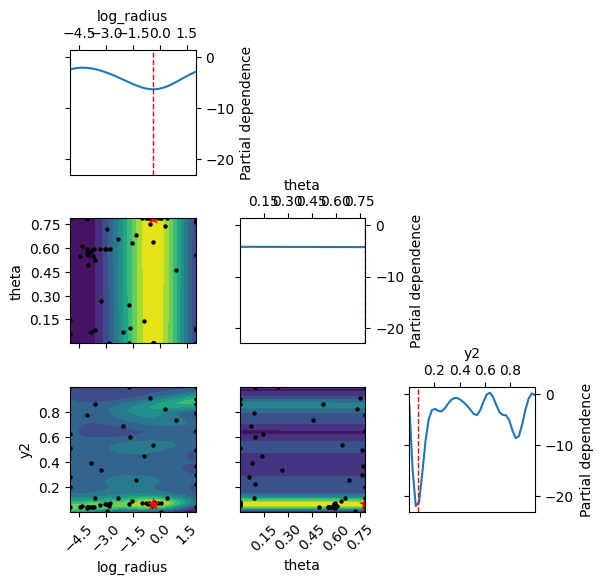

In [11]:
plot_objective(cr_gp)

# Plot policies

In [19]:
def get_policy_df(policy_obj, minx=-1, maxx=1, nx=500):
    obs_list = np.linspace(minx, maxx, nx)
    return pd.DataFrame(
        {
            'obs': obs_list,
            'biomass': env.bound * (obs_list + 1)/2,
            'fishing_mortality': [
                (1 + policy_obj.predict(np.float32([obs]))[0][0]) / 2 
                for obs in obs_list
            ]
        }
    )

In [20]:
cr_gp_preargs = {'log_radius': cr_gp.x[0], 'theta': cr_gp.x[1], 'y2': cr_gp.x[2]}
cr_gp_args = {}
cr_gp_args['x1'] = (10 ** cr_gp_preargs['log_radius']) * np.sin(cr_gp_preargs['theta'])
cr_gp_args['x2'] = (10 ** cr_gp_preargs['log_radius']) * np.cos(cr_gp_preargs['theta'])
cr_gp_args['y2'] = cr_gp_preargs['y2']

# cr_gbrt_preargs = {'log_radius': cr_gbrt.x[0], 'theta': cr_gbrt.x[1], 'y2': cr_gbrt.x[2]}
# cr_gbrt_args = {}
# cr_gbrt_args['x1'] = (10 ** cr_gbrt_preargs['log_radius']) * np.sin(cr_gbrt_preargs['theta'])
# cr_gbrt_args['x2'] = (10 ** cr_gbrt_preargs['log_radius']) * np.cos(cr_gbrt_preargs['theta'])
# cr_gbrt_args['y2'] = cr_gbrt_preargs['y2']

msy_gp_args = {'mortality': msy_gp.x[0]}
# msy_gbrt_args = {'mortality': msy_gbrt.x[0]}

esc_gp_args = {'escapement': 10 ** esc_gp.x[0]}
# esc_gbrt_args = {'escapement': 10 ** esc_gbrt.x[0]}

# cr_preargs = {'log_radius': 0.9991043655916663, 'theta': 0.0, 'y2': 0.3647240347805972}
# cr_args = {
#     'x1': (10 ** cr_preargs['log_radius']) * np.sin(cr_preargs['theta']),
#     'x2': (10 ** cr_preargs['log_radius']) * np.cos(cr_preargs['theta']),
#     'y2': cr_preargs['y2'],
# }

# esc_args = {'escapement': 10 ** (-0.01050109469304239)}
# msy_args = {'mortality': 0.027374341105189527}

#

env = AsmEnv(config=CONFIG)

# cr_gbrt_df = get_policy_df(CautionaryRule(env, **cr_gbrt_args))
cr_gp_df = get_policy_df(CautionaryRule(env, **cr_gp_args))

# esc_gbrt_df = get_policy_df(ConstEsc(env, **esc_gbrt_args))
esc_gp_df = get_policy_df(ConstEsc(env, **esc_gp_args))

# msy_gbrt_df = get_policy_df(Msy(env, **msy_gbrt_args))
msy_gp_df = get_policy_df(Msy(env, **msy_gp_args))

(<Axes: title={'center': 'Cautionary Rule GP policy'}, xlabel='biomass'>,
 <Axes: title={'center': 'Const. Escapement GP policy'}, xlabel='biomass'>,
 <Axes: title={'center': 'MSY GP policy'}, xlabel='biomass'>)

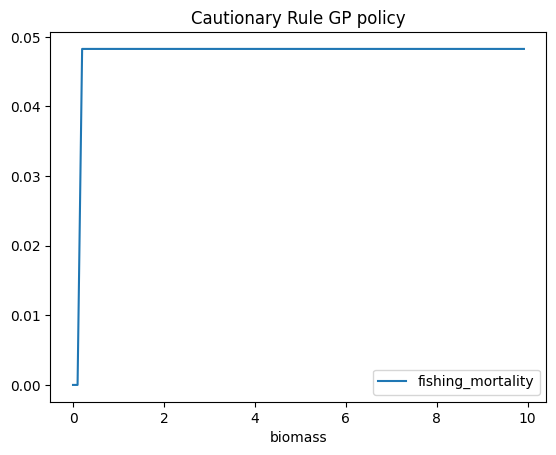

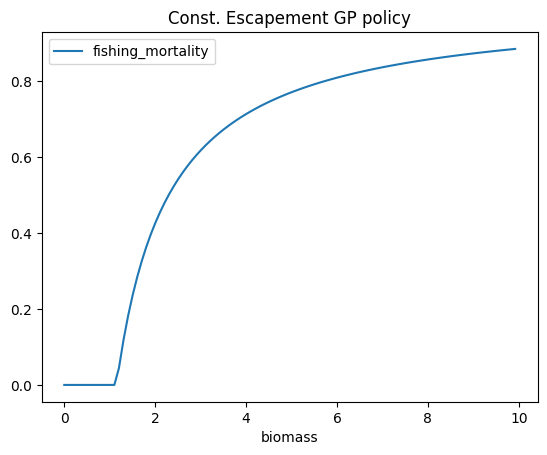

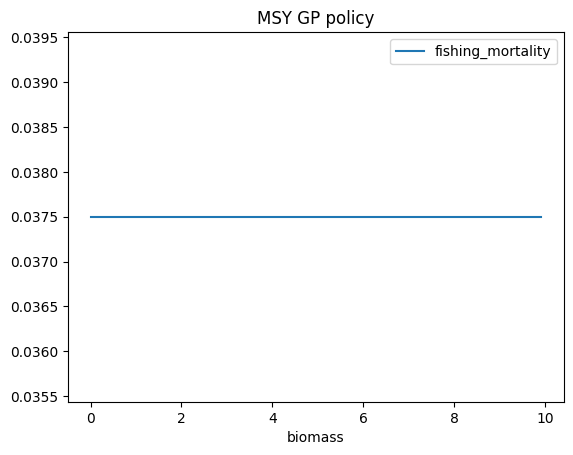

In [22]:
(
    cr_gp_df[cr_gp_df.biomass <= 10].plot(x='biomass', y='fishing_mortality', title='Cautionary Rule GP policy'),
    esc_gp_df[esc_gp_df.biomass <= 10].plot(x='biomass', y='fishing_mortality', title='Const. Escapement GP policy'),
    # cr_gbrt_df[cr_gbrt_df.biomass <= 15].plot(x='biomass', y='fishing_mortality', title='Cautionary Rule GBRT policy'),
    # esc_gbrt_df[esc_gbrt_df.biomass <= 7].plot(x='biomass', y='fishing_mortality', title='Const. Escapement GBRT policy'),
    msy_gp_df[msy_gp_df.biomass <= 10].plot(x='biomass', y='fishing_mortality', title='MSY GP policy'),
)  

# Saving results

### MSY

In [23]:
path = "../saved_agents/"
fname = "msy_gp_trophy.pkl"
dump(msy_gp, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

# path = "../saved_agents/"
# fname = "msy_gbrt.pkl"
# dump(msy_gbrt, path+fname)

# api.upload_file(
#     path_or_fileobj=path+fname,
#     path_in_repo="sb3/rl4fisheries/"+fname,
#     repo_id="boettiger-lab/rl4eco",
#     repo_type="model",
# )

msy_gp_trophy.pkl:   0%|          | 0.00/5.85M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/boettiger-lab/rl4eco/commit/e4dd5eeca2bac586de4c3d2eaa0f12356abf66f9', commit_message='Upload sb3/rl4fisheries/msy_gp_trophy.pkl with huggingface_hub', commit_description='', oid='e4dd5eeca2bac586de4c3d2eaa0f12356abf66f9', pr_url=None, pr_revision=None, pr_num=None)

### Esc

In [24]:
path = "../saved_agents/"
fname = "esc_gp_trophy.pkl"
dump(esc_gp, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

# path = "../saved_agents/"
# fname = "esc_gbrt.pkl"
# dump(esc_gbrt, path+fname)

# api.upload_file(
#     path_or_fileobj=path+fname,
#     path_in_repo="sb3/rl4fisheries/"+fname,
#     repo_id="boettiger-lab/rl4eco",
#     repo_type="model",
# )

esc_gp_trophy.pkl:   0%|          | 0.00/5.85M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/boettiger-lab/rl4eco/commit/3e7085b5f628ba841ac13e2d3aa0c8af342f933d', commit_message='Upload sb3/rl4fisheries/esc_gp_trophy.pkl with huggingface_hub', commit_description='', oid='3e7085b5f628ba841ac13e2d3aa0c8af342f933d', pr_url=None, pr_revision=None, pr_num=None)

### CR

In [25]:
path = "../saved_agents/"
fname = "cr_gp_trophy.pkl"
dump(cr_gp, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

# path = "../saved_agents/"
# fname = "cr_gbrt.pkl"
# dump(cr_gbrt, path+fname)

# api.upload_file(
#     path_or_fileobj=path+fname,
#     path_in_repo="sb3/rl4fisheries/"+fname,
#     repo_id="boettiger-lab/rl4eco",
#     repo_type="model",
# )

cr_gp_trophy.pkl:   0%|          | 0.00/5.96M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/boettiger-lab/rl4eco/commit/d04aa72d3b11320841c9e264493cdf0f521b9acf', commit_message='Upload sb3/rl4fisheries/cr_gp_trophy.pkl with huggingface_hub', commit_description='', oid='d04aa72d3b11320841c9e264493cdf0f521b9acf', pr_url=None, pr_revision=None, pr_num=None)

# Cross evaluate

In [15]:
# msy_gbrt_args = {'mortality': 0.05365088255575121}
# esc_gbrt_args = {'escapement': 0.010338225232077163}
# cr_gbrt_args = {
#     'x1': 0.009159055923137423,
#     'x2': 0.015139834077385755,
#     'y2': 0.29119675741251316,
# }

In [23]:
pol_env = AsmEnv(config=CONFIG)

msy_rews = eval_pol(
    policy=Msy(env=pol_env, **msy_gp_args), 
    env_cls=AsmEnv, config=CONFIG, 
    n_batches=1, batch_size=200
)

esc_rews = eval_pol(
    policy=ConstEsc(env=pol_env, **esc_gp_args), 
    env_cls=AsmEnv, config=CONFIG, 
    n_batches=1, batch_size=200
)

cr_rews = eval_pol(
    policy=CautionaryRule(env=pol_env, **cr_gp_args), 
    env_cls=AsmEnv, config=CONFIG, 
    n_batches=1, batch_size=200
)

2024-05-07 23:33:44,859	INFO worker.py:1749 -- Started a local Ray instance.
2024-05-07 23:33:52,847	INFO worker.py:1749 -- Started a local Ray instance.
2024-05-07 23:34:01,380	INFO worker.py:1749 -- Started a local Ray instance.


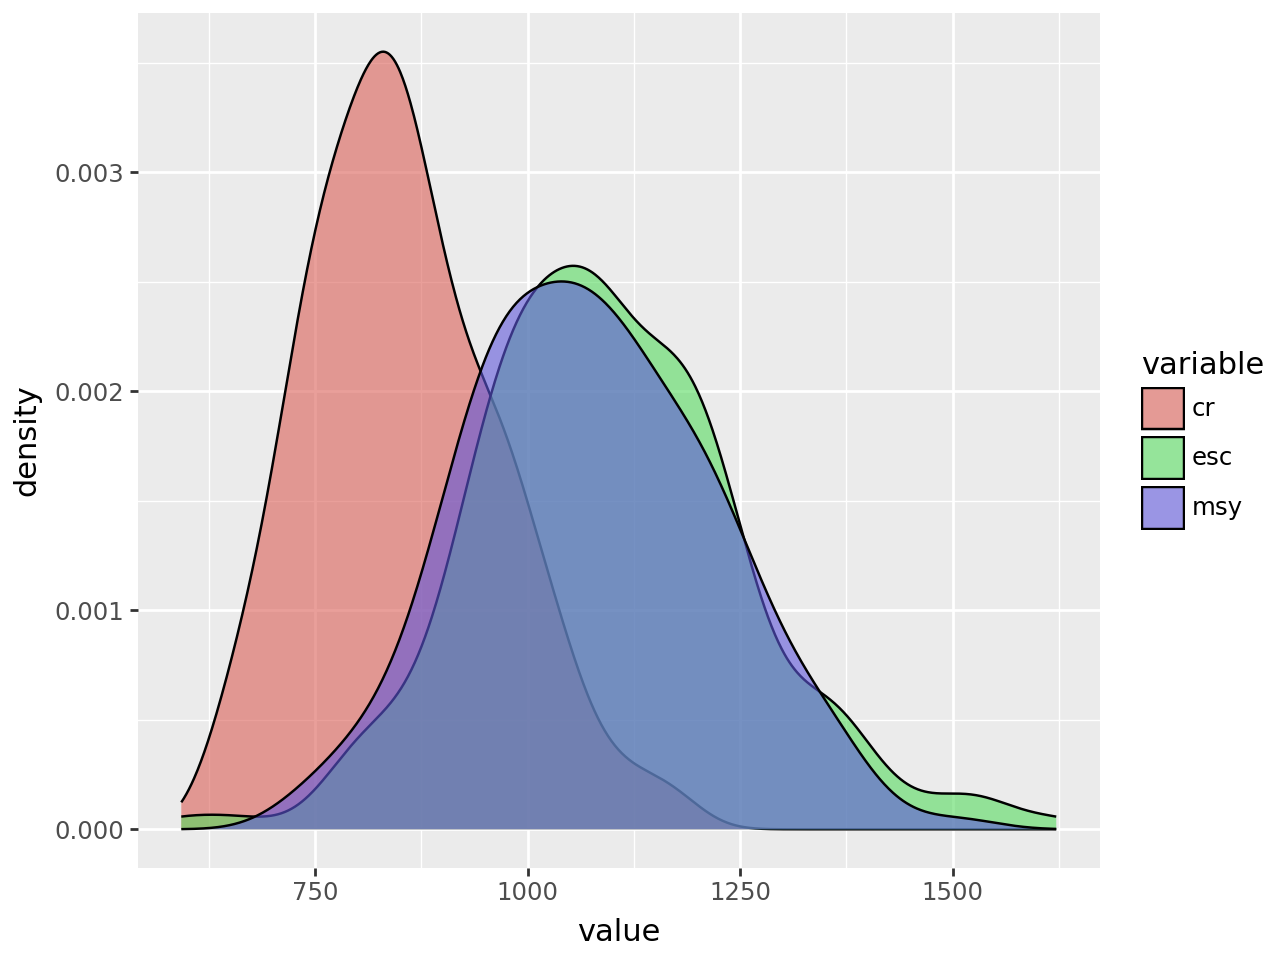

In [25]:
from plotnine import ggplot, aes, geom_point, geom_jitter, geom_density

df = pd.DataFrame({
    'msy': msy_rews,
    'esc': esc_rews,
    'cr': cr_rews,
}).melt()
df.head()
ggplot(df, aes(x='variable', y='value', color='variable')) + geom_point() + geom_jitter() 
ggplot(df, aes(x='value', fill='variable'))+ geom_density(alpha=0.6)

In [17]:
# df.to_csv("fixed_policies_rews.csv")
np.mean(df[df.variable=='esc'].value)

110.270450891279

In [18]:
(
    msy_gp_args, # {'mortality': 0.055692588594477406}
    esc_gp_args, # {'escapement': 0.10036884302580139}
    cr_gp_args,
# ({'mortality': 0.05365088255575121},
 # {'escapement': 0.010338225232077163},
 # {'x1': 0.009159055923137423,
 #  'x2': 0.015139834077385755,
 #  'y2': 0.29119675741251316})
)

({'mortality': 0.04473718126536452},
 {'escapement': 0.3972769224603838},
 {'x1': 0.0, 'x2': 1.0, 'y2': 0.13207767948328275})

In [89]:
msy_gp_args = {'mortality': 0.05365088255575121}
esc_gp_args = {'escapement': 0.010338225232077163}
cr_gp_args = {
    'x1': 0.009159055923137423,
    'x2': 0.015139834077385755,
    'y2': 0.29119675741251316
}

## Evaluate RL too

In [21]:
pol_env = AsmEnv(config=CONFIG)

msy_rews = eval_pol(
    policy=Msy(env=pol_env, **msy_args), 
    env_cls=AsmEnv, config=PPO_CONFIG, 
    n_batches=1, batch_size=200,
)

esc_rews = eval_pol(
    policy=ConstEsc(env=pol_env, **esc_args), 
    env_cls=AsmEnv, config=PPO_CONFIG, 
    n_batches=1, batch_size=200,
)

cr_rews = eval_pol(
    policy=CautionaryRule(env=pol_env, **cr_args), 
    env_cls=AsmEnv, config=PPO_CONFIG, 
    n_batches=1, batch_size=200,
)

2024-05-07 20:36:25,106	INFO worker.py:1749 -- Started a local Ray instance.
2024-05-07 20:36:32,062	INFO worker.py:1749 -- Started a local Ray instance.
2024-05-07 20:36:38,881	INFO worker.py:1749 -- Started a local Ray instance.


In [18]:
from stable_baselines3 import PPO
from rl4fisheries import AsmCRLike

PPO_CONFIG = {
    "observation_fn_id": 'observe_2o',
    "n_observs": 2,
    "upow": 0.6,
    "use_custom_harv_vul": True,
    "use_custom_surv_vul": True,
}

ppo = PPO.load(
    "../saved_agents/PPO-AsmCRLike-2o-lgBatch-slow-deep-upow0.6-flatHarvSurv", 
    env=AsmCRLike(config=PPO_CONFIG), 
    device='cpu',
)

In [19]:
# ppo_rews = evaluate_policy(
#     ppo, env=Monitor(AsmEnv(
#         config=PPO_CONFIG
#     )), 
#     return_episode_rewards=True,
#     n_eval_episodes = 200,
# )[0]

ppo_rews = eval_pol(
    policy=ppo, 
    env_cls=AsmCRLike, config=PPO_CONFIG, 
    n_batches=1, batch_size=200
)

In [22]:
msy_df = pd.DataFrame(
    {
        'policy': ['msy'] * len(msy_rews),
        'rew': msy_rews,
    }
)

esc_df = pd.DataFrame(
    {
        'policy': ['esc'] * len(esc_rews),
        'rew': esc_rews,
    }
)

cr_df = pd.DataFrame(
    {
        'policy': ['cr'] * len(cr_rews),
        'rew': cr_rews,
    }
)

ppo_df = pd.DataFrame(
    {
        'policy': ['ppo'] * len(ppo_rews),
        'rew': ppo_rews,
    }
)

evaluation = pd.concat([msy_df, esc_df, cr_df, ppo_df])

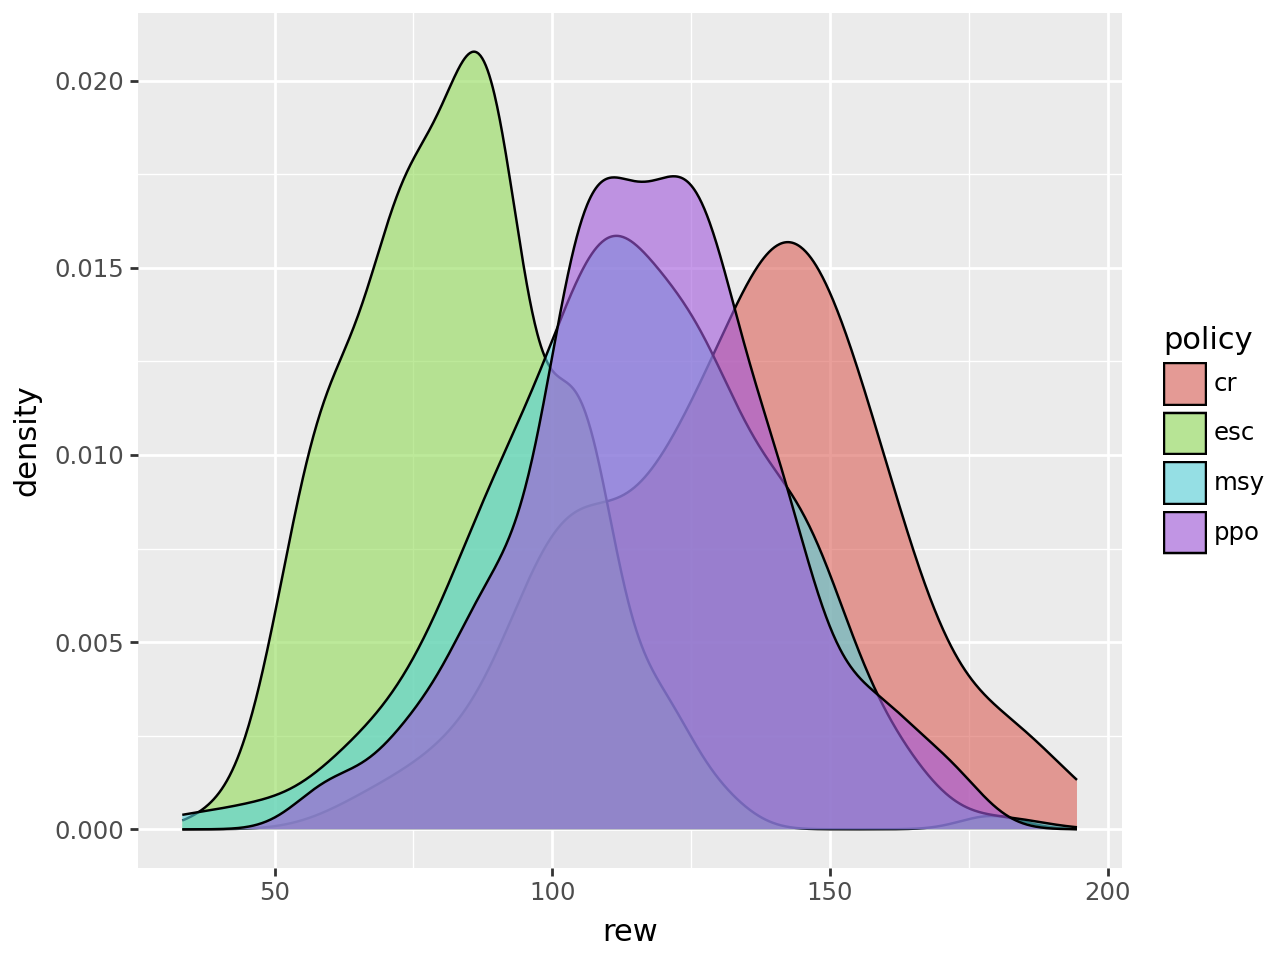

In [23]:
from plotnine import ggplot, aes, geom_density
ggplot(evaluation, aes(x='rew', fill='policy')) + geom_density(alpha=0.6)

## Plotting the RL policy

In [1]:
import itertools
env = AsmEnv()
BOUND = env.bound
MAXWT = env.parameters["max_wt"]
MINWT = env.parameters["min_wt"]

def harv_per_biomass(policy_obj, biomass_obs_list, column_name='fishing_mortality'):
    return [
                (1 + policy_obj.predict(np.float32([obs]))[0][0]) / 2 
                for obs in biomass_obs_list
            ]


def policy_crlike(policy_obj, minx=-1, maxx=1, nx=5):
    obs_list = np.linspace(minx, maxx, nx)
    policy_dict = {}
    for obs in obs_list:
        x1_act, x2_act, y2_act = policy_obj.predict(np.array([obs]))[0]
        x1 = 10 * (x1_act + 1) / 2
        x2 = 10 * (x2_act + 1) / 2
        y2 = (y2 + 1) / 2 

        harvests_at_mwt = harv_per_biomass(
            CautionaryRule(AsmEnv(config=CONFIG), x1=x1, x2=x2, y2=y2),
            np.linspace(-1, 1, 200),
        )

        mwt = MINWT + (MAXWT - MINWT) * (obs+1)/2

        policy_dict[f"mwt_{mwt}"] = harvests_at_mwt
    
    return policy_dict

def policy_1obs(policy_obj, minx=-1, maxx=1, nx=200):
    obs_list = np.linspace(minx, maxx, nx)
    return {
            'obs': obs_list,
            'pop': (obs_list + 1)/2,
            'pol': [policy_obj.predict(np.array([obs]))[0][0] for obs in obs_list]
        }

def policy_2obs(policy_obj, minx=-1, miny=-1, maxx=1, maxy=1, nx=100, ny=100, obs1_name = 'obs1', obs2_name='obs2'):
    x_obs = np.linspace(minx, maxx, nx)
    y_obs = np.linspace(miny, maxy, ny)
    obs_generator = itertools.product(x_obs, y_obs)
    # obs_list = list(obs_generator)
    out_dict = {obs1_name: [], obs2_name: [], 'pol': []}
    for (obs1, obs2) in obs_generator:
        out_dict[obs1_name].append( BOUND * (obs1+1)/2 )
        out_dict[obs2_name].append( MINWT + (MAXWT - MINWT) * (obs2+1)/2 )
        action = policy_obj.predict(np.float32([obs1, obs2]))[0][0]
        mortality = (action+1)/2
        out_dict['pol'].append(mortality)
    
    return out_dict

NameError: name 'AsmEnv' is not defined

In [56]:
AsmEnv().bound

50

In [57]:
# %pip install seaborn

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
# plt.close()

maxx=-0.7
maxy=1
n_ticks = 10

ppo_pol = pd.DataFrame(policy_2obs(ppo, maxx=maxx, maxy=maxy, obs1_name='biomass', obs2_name='mean_wt'))
ppo_pol_pivot = ppo_pol.pivot(index='biomass', columns='mean_wt', values='pol')


In [102]:
plt.close()

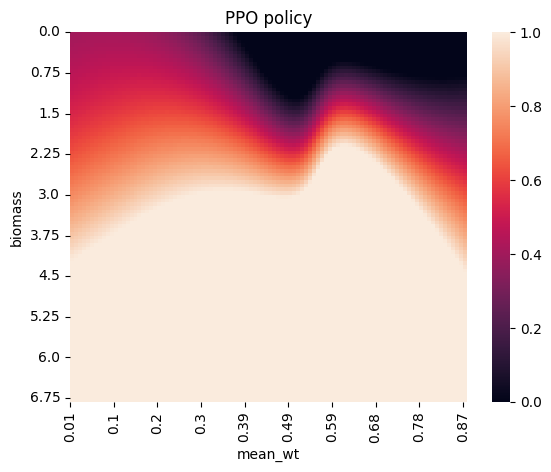

In [103]:
ax = sns.heatmap(ppo_pol_pivot)
ax.set_yticks(list(range(0, 101, 100//n_ticks + 1))) # locations as indices, not values
ax.set_yticklabels([eval(f"{ (i / n_ticks) * BOUND * (maxx+1)/ 2 :.2f}") for i in range(n_ticks)])
ax.set_xticks(list(range(0, 101, 100//n_ticks + 1))) # locations as indices, not values
ax.set_xticklabels([
    eval(f"{ MINWT + (i / n_ticks) * (MAXWT-MINWT) * (maxy+1)/ 2:.2f}") for i in range(n_ticks)
])
ax.set_title("PPO policy")
plt.show()

In [104]:
wt_indexes = [40, 50, 60, 45]

ppo_pol_1 = ppo_pol[ppo_pol.mean_wt == ppo_pol.mean_wt[wt_indexes[0]]]
ppo_pol_2 = ppo_pol[ppo_pol.mean_wt == ppo_pol.mean_wt[wt_indexes[1]]]
ppo_pol_3 = ppo_pol[ppo_pol.mean_wt == ppo_pol.mean_wt[wt_indexes[2]]]
ppo_pol_4 = ppo_pol[ppo_pol.mean_wt == ppo_pol.mean_wt[wt_indexes[3]]]



ppo_plot = pd.DataFrame(
    {
        'biomass': list(ppo_pol_1.biomass),
        f'action at m. wt = {ppo_pol.mean_wt[wt_indexes[0]]:.3f}': list(ppo_pol_1.pol),
        f'action at m. wt = {ppo_pol.mean_wt[wt_indexes[3]]:.3f}': list(ppo_pol_4.pol),
        f'action at m. wt = {ppo_pol.mean_wt[wt_indexes[1]]:.3f}': list(ppo_pol_2.pol),
        f'action at m. wt = {ppo_pol.mean_wt[wt_indexes[2]]:.3f}': list(ppo_pol_3.pol),
    }
)



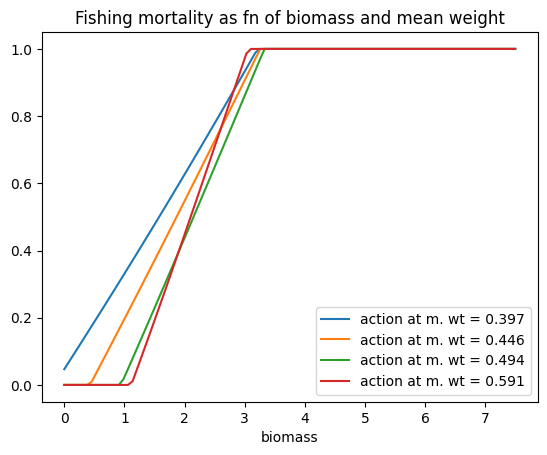

In [105]:
ppo_plot.plot(x='biomass', title="Fishing mortality as fn of biomass and mean weight")
plt.show()

In [111]:
cr_pol_df = cr_gbrt_df[cr_gbrt_df.biomass <= 7][['biomass', 'fishing_mortality']]
cr_pol_df['policy'] = 'cr'

esc_pol_df = esc_gbrt_df[esc_gbrt_df.biomass <= 7][['biomass', 'fishing_mortality']]
esc_pol_df['policy'] = 'esc'

ppo_pol_df_1 = ppo_pol_1
ppo_pol_df_1['policy'] = 'ppo_mwt_0.397'
ppo_pol_df_1['fishing_mortality'] = ppo_pol_df_1['pol']

ppo_pol_df_2 = ppo_pol_2
ppo_pol_df_2['policy'] = 'ppo_mwt_0.494'
ppo_pol_df_2['fishing_mortality'] = ppo_pol_df_2['pol']

ppo_pol_df_3 = ppo_pol_3
ppo_pol_df_3['policy'] = 'ppo_mwt_0.591'
ppo_pol_df_3['fishing_mortality'] = ppo_pol_df_3['pol']

ppo_pol_df_4 = ppo_pol_4
ppo_pol_df_4['policy'] = 'ppo_mwt_0.446'
ppo_pol_df_4['fishing_mortality'] = ppo_pol_df_4['pol']

df = pd.concat([
    cr_pol_df,
    esc_pol_df,
    ppo_pol_df_1[esc_pol_df.columns],
    ppo_pol_df_4[esc_pol_df.columns],
    ppo_pol_df_2[esc_pol_df.columns],
    ppo_pol_df_3[esc_pol_df.columns],
])


/tmp/ipykernel_1226226/693145116.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1226226/693145116.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1226226/693145116.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_122

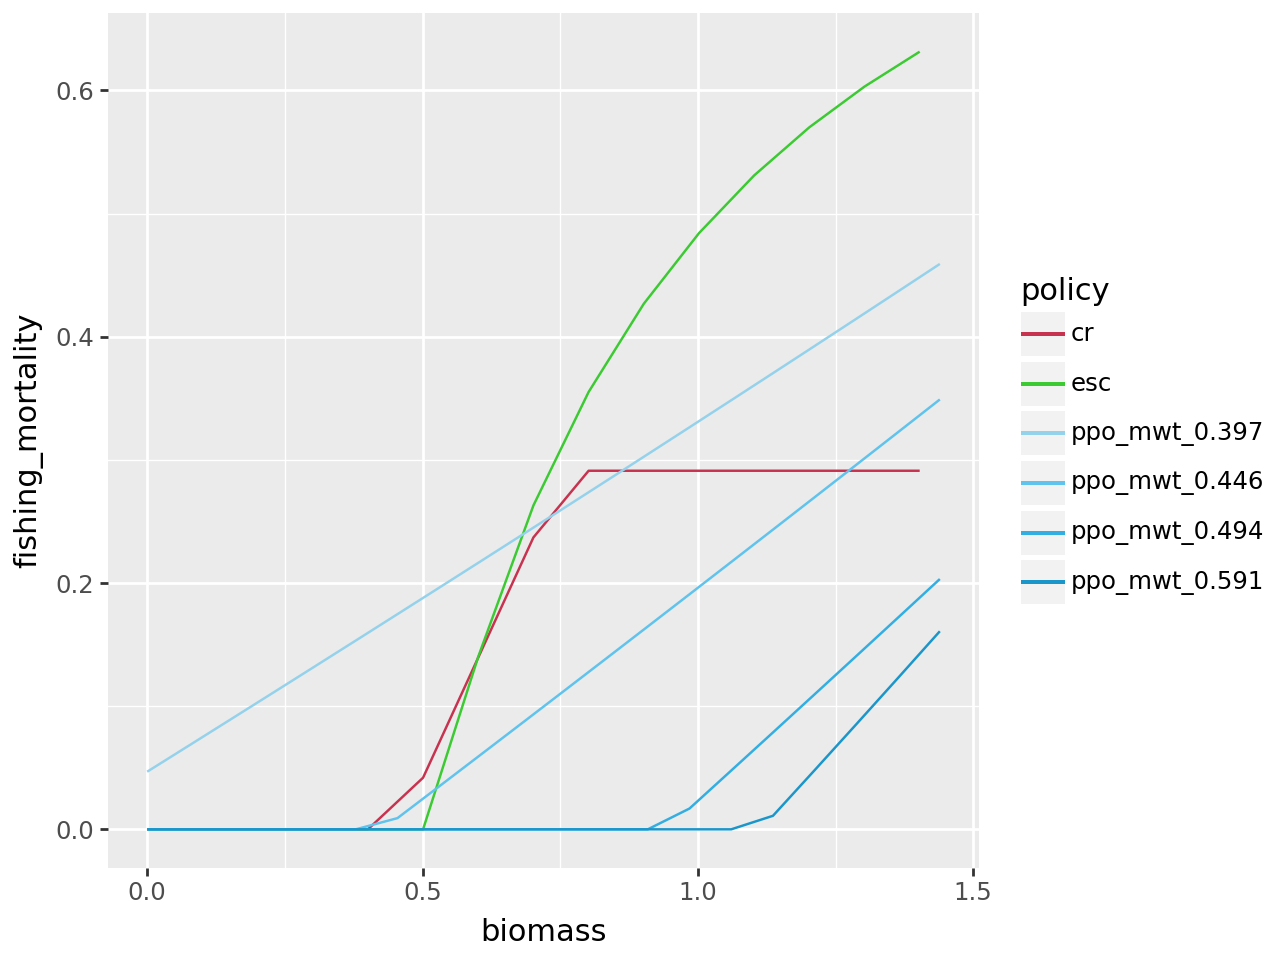

In [112]:
from plotnine import geom_line, scale_color_manual

colors = {
    'ppo_mwt_0.397': '#94D2EC',
    'ppo_mwt_0.446': '#5FC3ED',
    'ppo_mwt_0.494': '#32AEE2',
    'ppo_mwt_0.591': '#1B96CA',
    'esc': '#3CCA33',
    'cr': '#C7324F',
}

( 
    ggplot(df[df.biomass < 1.5], aes(x='biomass', y='fishing_mortality',  color='policy')) 
    + geom_line() 
    + scale_color_manual(values=colors)
)

## Variable density plots

In [67]:
@ray.remote
def variable_values_over_ep(env, agent, n_obs=1):
    obs1_list = []
    obs2_list = []
    act_list = []
    rew_list = []
    obs, info = env.reset()
    for t in range(env.Tmax):
        action, info = agent.predict(obs)
        new_obs, rew, term, trunc, info = env.step(action)
        obs1_list.append(obs[0])
        if n_obs == 2:
            obs2_list.append(obs[1])
        else:
            obs2_list.append(0)
        act_list.append(action[0])
        rew_list.append(rew)
        obs = new_obs
        if term or trunc:
            break
    return obs1_list, obs2_list, act_list, rew_list


def get_var_distributions(agent, agent_name, env, n_obs=1):
    var_tuples_of_lists = ray.get(
        [
            variable_values_over_ep.remote(env, agent) for _ in range(10)
        ]
    )
    if ray.is_initialized():
        ray.shutdown()
    
    obs1 = np.array([tup[0] for tup in var_tuples_of_lists]).flatten()
    obs2 = np.array([tup[1] for tup in var_tuples_of_lists]).flatten()
    act = np.array([tup[2] for tup in var_tuples_of_lists]).flatten()
    rew = np.array([tup[3] for tup in var_tuples_of_lists]).flatten()

    biomass = BOUND * (obs1 + 1)/2
    if n_obs==2:
        mean_wt = MINWT + (MAXWT - MINWT) * (obs2 + 1)/2
    else:
        mean_wt = obs2
    mortality = (act + 1)/2

    return pd.DataFrame({
        'agent': agent_name,
        'biomass': biomass,
        'mean_wt': mean_wt,
        'mortality': mortality,
        'rew': rew,
    })

In [76]:
ppo_distr_df = get_var_distributions(
    agent=ppo, 
    agent_name='ppo', 
    env = AsmEnv(config=PPO_CONFIG), 
    n_obs=2,
)

cr_distr_df = get_var_distributions(
    agent=CautionaryRule(env=pol_env, **cr_gbrt_args), 
    agent_name='cr', 
    env = AsmEnv(config=PPO_CONFIG), 
    n_obs=2,
)

esc_distr_df = get_var_distributions(
    agent=ConstEsc(env=pol_env, **esc_gbrt_args), 
    agent_name='esc', 
    env = AsmEnv(config=PPO_CONFIG), 
    n_obs=2,
)

2024-04-19 20:32:29,101	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 20:32:38,134	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-19 20:32:45,098	INFO worker.py:1752 -- Started a local Ray instance.


In [77]:
vars_df = pd.concat([ppo_distr_df, cr_distr_df, esc_distr_df])

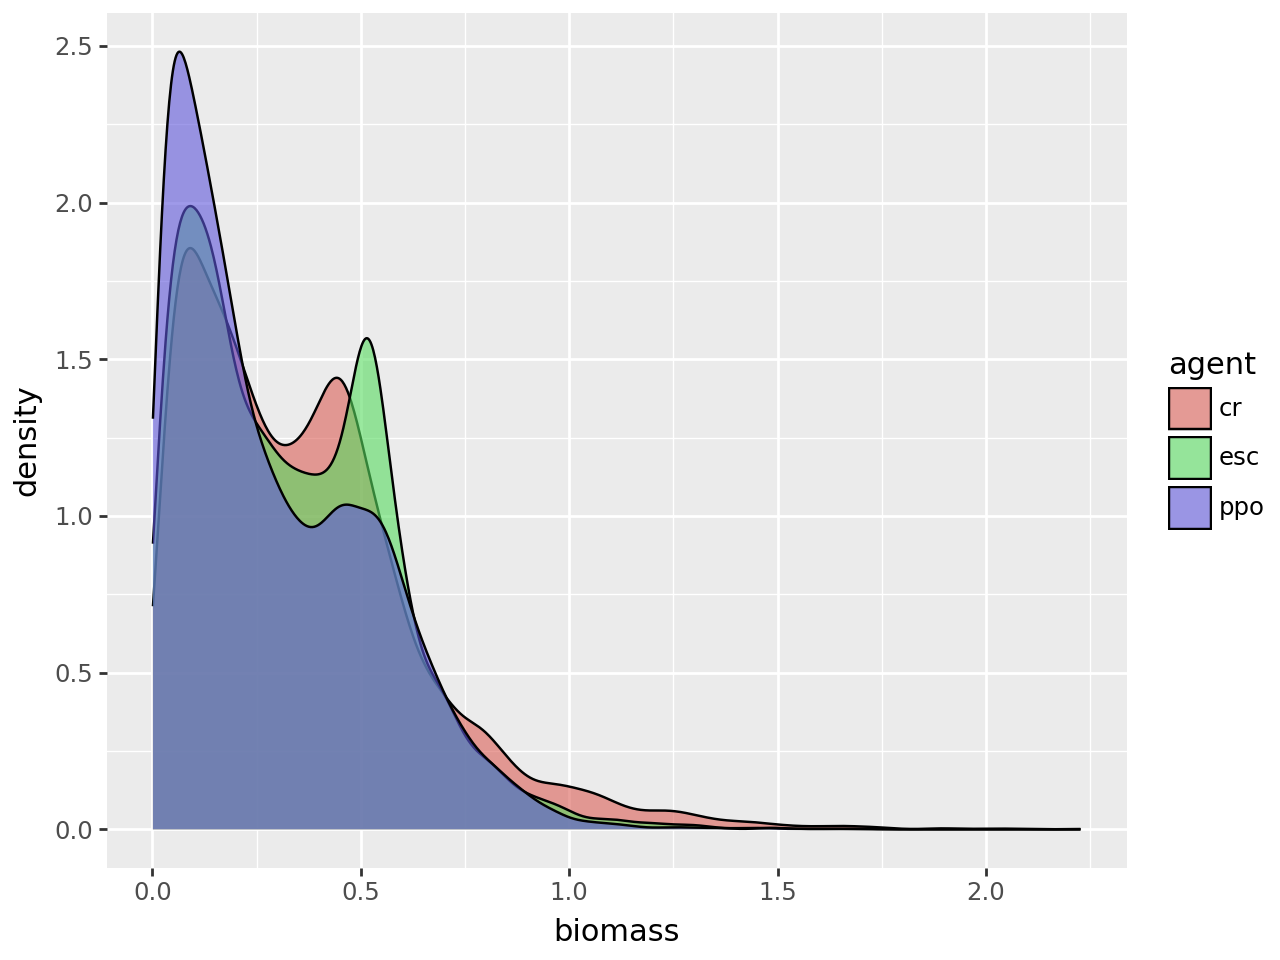

In [78]:
ggplot(vars_df, aes(x='biomass', fill='agent')) + geom_density(alpha=0.6)

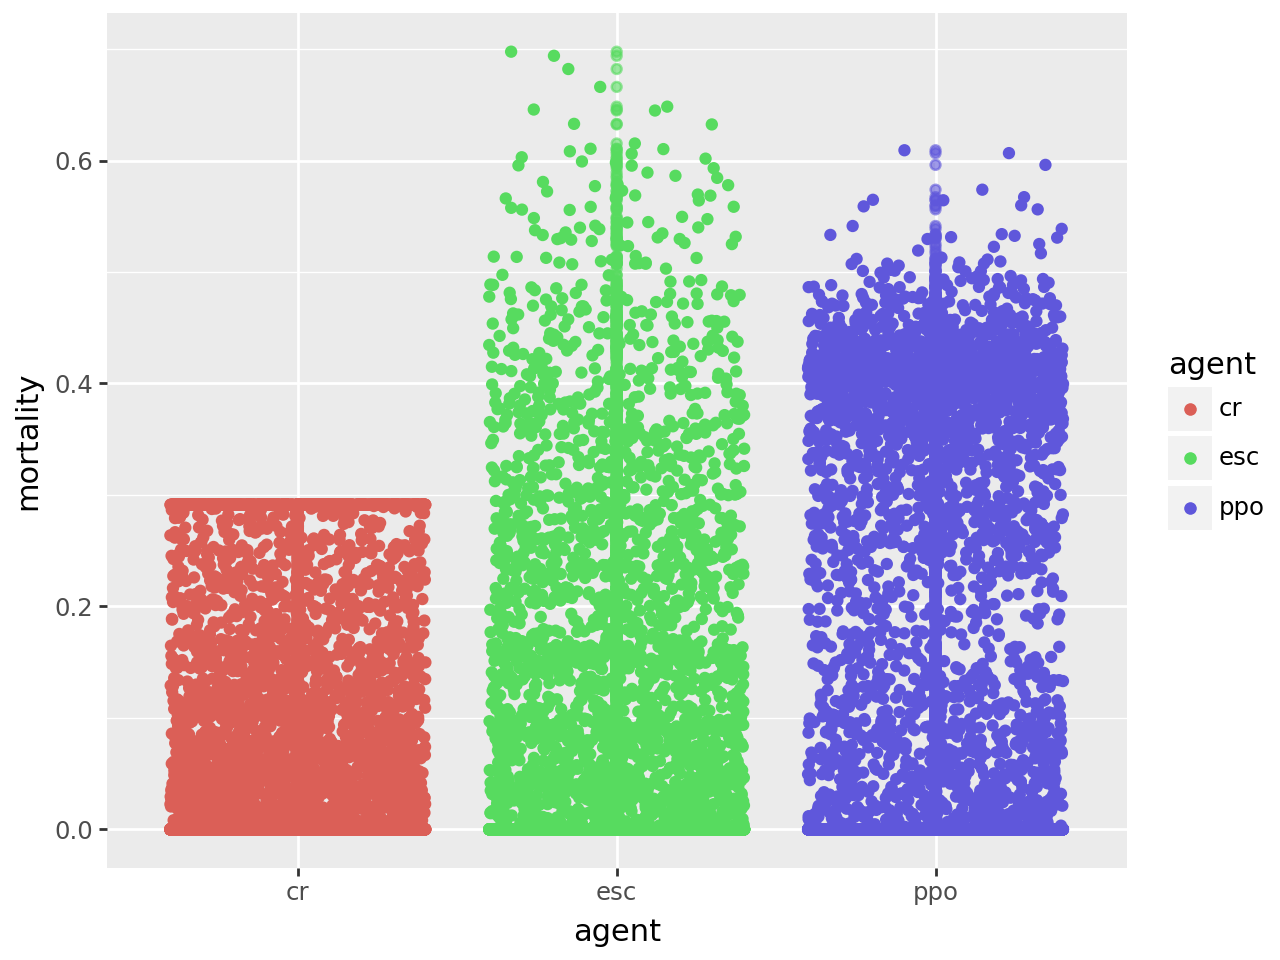

In [79]:
# from plotnine import scale_x_log10, xlim, scale_y_log10
# ggplot(vars_df, aes(x='mortality', fill='agent')) + geom_density(alpha=0.6) + xlim(0,0.5) + scale_y_log10()

ggplot(vars_df, aes(y='mortality', x='agent',color='agent')) + geom_point(alpha=0.6) + geom_jitter()

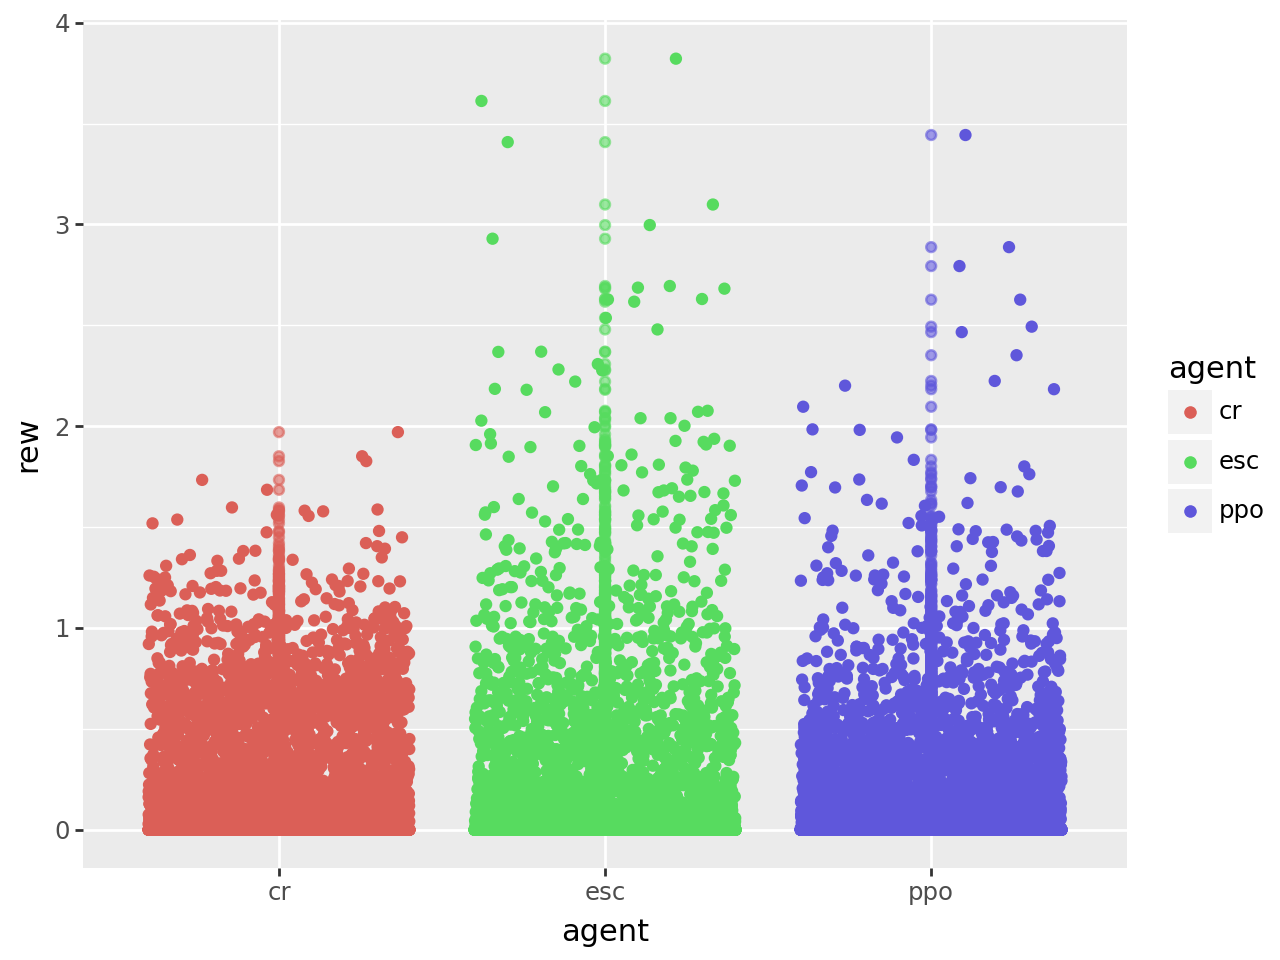

In [80]:
# ggplot(vars_df, aes(x='rew', fill='agent')) + geom_density(alpha=0.6) + scale_x_log10()
ggplot(vars_df, aes(y='rew', x='agent',color='agent')) + geom_point(alpha=0.6) + geom_jitter()

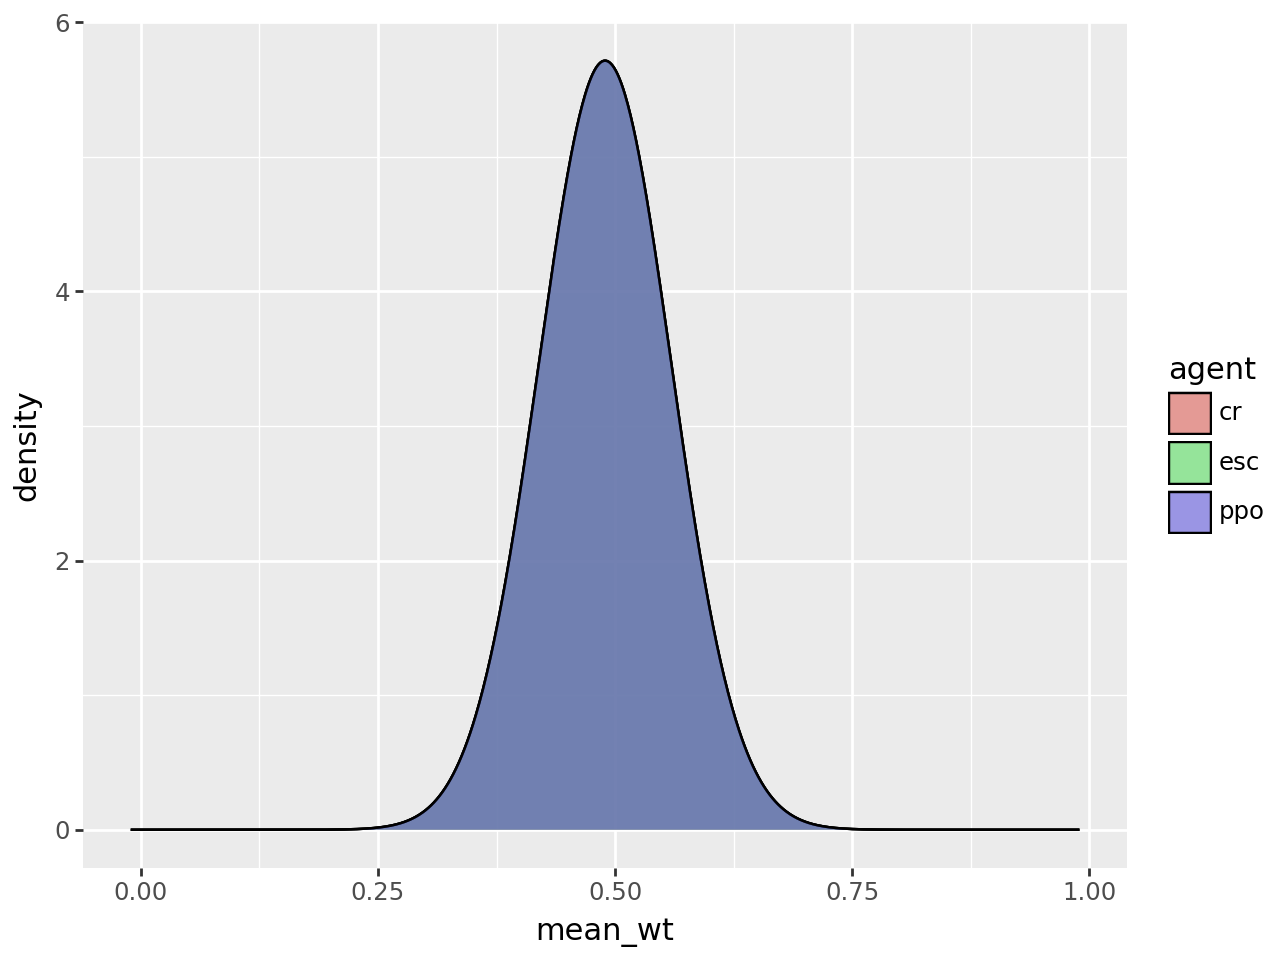

In [82]:
ggplot(vars_df, aes(x='mean_wt', fill='agent')) + geom_density(alpha=0.6)
# ggplot(vars_df, aes(y='mean_wt', x='agent',color='agent')) + geom_point(alpha=0.6) + geom_jitter()

In [119]:
MINWT, MAXWT

(0.00867406, 0.9701466)

In [ ]:
from plotnine import xlim

ggplot(vars_df, aes(x='mortality', fill='agent')) + geom_density(alpha=0.6) + xlim(0,0.1)

In [ ]:
ggplot(vars_df, aes(y='mortality', x='agent', color='agent')) + geom_point() + geom_jitter() + xlim(0,0.1)

# Observing mean weight instead of biomass
---
## Setup


In [1]:
import numpy as np
import pandas as pd
import ray

from skopt import gp_minimize, gbrt_minimize 
from skopt import dump
from skopt.plots import plot_objective, plot_convergence
from skopt.space import Real
from skopt.utils import use_named_args

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

from rl4fisheries import AsmEnv, Msy, ConstEsc, CautionaryRule
from rl4fisheries.envs.asm_fns import get_r_devs, observe_total

In [2]:
CONFIG = {
    'observation_fn_id': 'observe_2o', 
    'n_observs': 2, 
}

In [3]:
@ray.remote
def generate_rew(policy, env_cls, config):
    ep_rew = 0
    env = env_cls(config=config)
    obs, info = env.reset()
    for t in range(env.Tmax):
        act, info = policy.predict(obs)
        obs, rew, term, trunc, info = env.step(act)
        ep_rew += rew
    return ep_rew


def rew_batch(policy, env_cls, config, batch_size):
    tmax = env_cls().Tmax
    parallel = [generate_rew.remote(policy, env_cls, config) for _ in range(batch_size)]
    rews = ray.get(parallel)
    if ray.is_initialized():
        ray.shutdown()
    return rews

def eval_pol(policy, env_cls, config, n_batches=4, batch_size=40, pb=False):
    batch_iter = range(n_batches)
    if pb:
        from tqdm import tqdm
        batch_iter = tqdm(iter)
    #
    rews = []
    for i in batch_iter:
        rews.append(
            rew_batch(policy=policy, env_cls=env_cls, config=config, batch_size=batch_size)
        )
    return np.array(rews).flatten()

In [4]:
log_esc_space = [Real(-6, 2, name='log_escapement')]
cr_space  = [
    Real(-5, 0, name='log_radius'),
    Real(0., np.pi/4.00001, name='theta'),
    Real(0, 1, name='y2'),
]


@use_named_args(log_esc_space)
def esc_mw_obj(**x):
    eval_env = AsmEnv(config=CONFIG)
    escapement = 10 ** x['log_escapement']
    agent = ConstEsc(
        env=eval_env, 
        escapement=escapement, 
        observed_var='mean_wt',
    )
    rews = eval_pol(
        policy=agent, 
        env_cls=AsmEnv, config=CONFIG, 
        n_batches=1, batch_size=200
    )
    return -np.mean(rews)

@use_named_args(cr_space)
def cr_mwt_obj(**x):
    theta = x["theta"]
    radius = 10 ** x["log_radius"]
    x1 = np.sin(theta) * radius
    x2 = np.cos(theta) * radius
    #
    eval_env = AsmEnv(config=CONFIG)
    eval_env.reset()
    agent = CautionaryRule(
        env=eval_env, 
        x1=x1, x2=x2, y2=x["y2"],
        observed_var='mean_wt',
    )
    rews = eval_pol(
        policy=agent, 
        env_cls=AsmEnv, 
        config=CONFIG, 
        n_batches=1, batch_size=200
    )
    return -np.mean(rews)  



In [5]:
%%time
esc_gp = gp_minimize(esc_mw_obj, log_esc_space, n_calls = 50, verbose=True, n_jobs=-1)
esc_gp.fun, esc_gp.x

Iteration No: 1 started. Evaluating function at random point.


2024-04-25 18:36:40,150	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.5964
Function value obtained: -1.9301
Current minimum: -1.9301
Iteration No: 2 started. Evaluating function at random point.


2024-04-25 18:36:48,701	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.8739
Function value obtained: -1.8447
Current minimum: -1.9301
Iteration No: 3 started. Evaluating function at random point.


2024-04-25 18:36:56,547	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 8.6655
Function value obtained: -2.9466
Current minimum: -2.9466
Iteration No: 4 started. Evaluating function at random point.


2024-04-25 18:37:05,224	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 8.6346
Function value obtained: -2.0565
Current minimum: -2.9466
Iteration No: 5 started. Evaluating function at random point.


2024-04-25 18:37:13,859	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 8.4440
Function value obtained: -1.9924
Current minimum: -2.9466
Iteration No: 6 started. Evaluating function at random point.


2024-04-25 18:37:22,326	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 7.8105
Function value obtained: -1.9986
Current minimum: -2.9466
Iteration No: 7 started. Evaluating function at random point.


2024-04-25 18:37:30,148	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 8.6142
Function value obtained: -1.8612
Current minimum: -2.9466
Iteration No: 8 started. Evaluating function at random point.


2024-04-25 18:37:38,743	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 8.7192
Function value obtained: -1.9489
Current minimum: -2.9466
Iteration No: 9 started. Evaluating function at random point.


2024-04-25 18:37:47,463	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 8.6512
Function value obtained: -3.6397
Current minimum: -3.6397
Iteration No: 10 started. Evaluating function at random point.


2024-04-25 18:37:56,166	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 12.5335
Function value obtained: -1.9026
Current minimum: -3.6397
Iteration No: 11 started. Searching for the next optimal point.


2024-04-25 18:38:08,711	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 9.9853
Function value obtained: -4.1769
Current minimum: -4.1769
Iteration No: 12 started. Searching for the next optimal point.


2024-04-25 18:38:18,707	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 10.0685
Function value obtained: -4.9104
Current minimum: -4.9104
Iteration No: 13 started. Searching for the next optimal point.


2024-04-25 18:38:28,753	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 9.9638
Function value obtained: -30.9084
Current minimum: -30.9084
Iteration No: 14 started. Searching for the next optimal point.


2024-04-25 18:38:38,726	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 10.1723
Function value obtained: -43.9345
Current minimum: -43.9345
Iteration No: 15 started. Searching for the next optimal point.


2024-04-25 18:38:48,878	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 9.4033
Function value obtained: -35.1148
Current minimum: -43.9345
Iteration No: 16 started. Searching for the next optimal point.


2024-04-25 18:38:58,300	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 9.9715
Function value obtained: -39.9467
Current minimum: -43.9345
Iteration No: 17 started. Searching for the next optimal point.


2024-04-25 18:39:08,295	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 9.6872
Function value obtained: -41.4673
Current minimum: -43.9345
Iteration No: 18 started. Searching for the next optimal point.


2024-04-25 18:39:18,044	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 9.2898
Function value obtained: -0.0000
Current minimum: -43.9345
Iteration No: 19 started. Searching for the next optimal point.


2024-04-25 18:39:27,300	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 9.0895
Function value obtained: -39.4750
Current minimum: -43.9345
Iteration No: 20 started. Searching for the next optimal point.


2024-04-25 18:39:36,401	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 9.1824
Function value obtained: -39.9131
Current minimum: -43.9345
Iteration No: 21 started. Searching for the next optimal point.


2024-04-25 18:39:45,549	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 8.9877
Function value obtained: -38.6377
Current minimum: -43.9345
Iteration No: 22 started. Searching for the next optimal point.


2024-04-25 18:39:54,606	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 8.9698
Function value obtained: -0.0000
Current minimum: -43.9345
Iteration No: 23 started. Searching for the next optimal point.


2024-04-25 18:40:03,523	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 9.0596
Function value obtained: -0.0000
Current minimum: -43.9345
Iteration No: 24 started. Searching for the next optimal point.


2024-04-25 18:40:12,562	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 9.2469
Function value obtained: -41.3403
Current minimum: -43.9345
Iteration No: 25 started. Searching for the next optimal point.


2024-04-25 18:40:21,858	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 8.9188
Function value obtained: -1.9286
Current minimum: -43.9345
Iteration No: 26 started. Searching for the next optimal point.


2024-04-25 18:40:30,757	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 9.2686
Function value obtained: -0.0000
Current minimum: -43.9345
Iteration No: 27 started. Searching for the next optimal point.


2024-04-25 18:40:40,087	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 9.1510
Function value obtained: -38.9835
Current minimum: -43.9345
Iteration No: 28 started. Searching for the next optimal point.


2024-04-25 18:40:49,211	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 9.3303
Function value obtained: -0.0000
Current minimum: -43.9345
Iteration No: 29 started. Searching for the next optimal point.


2024-04-25 18:40:58,611	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 9.0922
Function value obtained: -1.9758
Current minimum: -43.9345
Iteration No: 30 started. Searching for the next optimal point.


2024-04-25 18:41:07,726	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 8.9833
Function value obtained: -40.0722
Current minimum: -43.9345
Iteration No: 31 started. Searching for the next optimal point.


2024-04-25 18:41:16,645	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 9.0641
Function value obtained: -1.9500
Current minimum: -43.9345
Iteration No: 32 started. Searching for the next optimal point.


2024-04-25 18:41:25,684	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 9.1091
Function value obtained: -1.9343
Current minimum: -43.9345
Iteration No: 33 started. Searching for the next optimal point.


2024-04-25 18:41:34,844	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 9.0716
Function value obtained: -39.6939
Current minimum: -43.9345
Iteration No: 34 started. Searching for the next optimal point.


2024-04-25 18:41:43,914	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 9.0792
Function value obtained: -1.9958
Current minimum: -43.9345
Iteration No: 35 started. Searching for the next optimal point.


2024-04-25 18:41:52,954	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 9.0826
Function value obtained: -1.9054
Current minimum: -43.9345
Iteration No: 36 started. Searching for the next optimal point.


2024-04-25 18:42:02,075	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 9.0319
Function value obtained: -40.6130
Current minimum: -43.9345
Iteration No: 37 started. Searching for the next optimal point.


2024-04-25 18:42:11,075	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 9.1230
Function value obtained: -40.7349
Current minimum: -43.9345
Iteration No: 38 started. Searching for the next optimal point.


2024-04-25 18:42:20,210	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 8.6547
Function value obtained: -39.1674
Current minimum: -43.9345
Iteration No: 39 started. Searching for the next optimal point.


2024-04-25 18:42:28,910	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 9.2671
Function value obtained: -2.0267
Current minimum: -43.9345
Iteration No: 40 started. Searching for the next optimal point.


2024-04-25 18:42:38,183	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 8.5154
Function value obtained: -39.9648
Current minimum: -43.9345
Iteration No: 41 started. Searching for the next optimal point.


2024-04-25 18:42:46,708	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 9.2752
Function value obtained: -39.9524
Current minimum: -43.9345
Iteration No: 42 started. Searching for the next optimal point.


2024-04-25 18:42:55,952	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 9.2019
Function value obtained: -39.9497
Current minimum: -43.9345
Iteration No: 43 started. Searching for the next optimal point.


2024-04-25 18:43:05,162	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 9.3917
Function value obtained: -40.6759
Current minimum: -43.9345
Iteration No: 44 started. Searching for the next optimal point.


2024-04-25 18:43:14,602	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 8.7284
Function value obtained: -0.0000
Current minimum: -43.9345
Iteration No: 45 started. Searching for the next optimal point.


2024-04-25 18:43:23,310	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 9.4948
Function value obtained: -40.7349
Current minimum: -43.9345
Iteration No: 46 started. Searching for the next optimal point.


2024-04-25 18:43:32,785	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 9.5088
Function value obtained: -41.3343
Current minimum: -43.9345
Iteration No: 47 started. Searching for the next optimal point.


2024-04-25 18:43:42,304	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 9.2649
Function value obtained: -0.0000
Current minimum: -43.9345
Iteration No: 48 started. Searching for the next optimal point.


2024-04-25 18:43:51,573	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 9.1430
Function value obtained: -40.2793
Current minimum: -43.9345
Iteration No: 49 started. Searching for the next optimal point.


2024-04-25 18:44:00,762	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 8.9883
Function value obtained: -39.1546
Current minimum: -43.9345
Iteration No: 50 started. Searching for the next optimal point.


2024-04-25 18:44:09,744	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 9.3150
Function value obtained: -38.7926
Current minimum: -43.9345
CPU times: user 7min 7s, sys: 9min 53s, total: 17min 1s
Wall time: 7min 38s


(-43.93454607110205, [-0.18751693186661367])

In [6]:
%%time
cr_gp = gp_minimize(cr_mwt_obj, cr_space, n_calls = 50, verbose=True, n_jobs=-1)
cr_gp.fun, cr_gp.x

Iteration No: 1 started. Evaluating function at random point.


2024-04-25 18:44:19,075	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.9138
Function value obtained: -1.9730
Current minimum: -1.9730
Iteration No: 2 started. Evaluating function at random point.


2024-04-25 18:44:28,024	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.9834
Function value obtained: -2.8469
Current minimum: -2.8469
Iteration No: 3 started. Evaluating function at random point.


2024-04-25 18:44:37,007	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 8.4480
Function value obtained: -2.4274
Current minimum: -2.8469
Iteration No: 4 started. Evaluating function at random point.


2024-04-25 18:44:45,460	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 9.0373
Function value obtained: -3.2697
Current minimum: -3.2697
Iteration No: 5 started. Evaluating function at random point.


2024-04-25 18:44:54,514	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 9.1095
Function value obtained: -2.3260
Current minimum: -3.2697
Iteration No: 6 started. Evaluating function at random point.


2024-04-25 18:45:03,648	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 9.0462
Function value obtained: -2.0956
Current minimum: -3.2697
Iteration No: 7 started. Evaluating function at random point.


2024-04-25 18:45:12,669	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 10.2570
Function value obtained: -3.4491
Current minimum: -3.4491
Iteration No: 8 started. Evaluating function at random point.


2024-04-25 18:45:22,941	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 8.6393
Function value obtained: -2.2414
Current minimum: -3.4491
Iteration No: 9 started. Evaluating function at random point.


2024-04-25 18:45:31,612	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 8.9456
Function value obtained: -2.1366
Current minimum: -3.4491
Iteration No: 10 started. Evaluating function at random point.


2024-04-25 18:45:40,530	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 9.3515
Function value obtained: -2.1085
Current minimum: -3.4491
Iteration No: 11 started. Searching for the next optimal point.


2024-04-25 18:45:49,852	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 9.2617
Function value obtained: -3.4426
Current minimum: -3.4491
Iteration No: 12 started. Searching for the next optimal point.


2024-04-25 18:45:59,135	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 9.3741
Function value obtained: -3.2485
Current minimum: -3.4491
Iteration No: 13 started. Searching for the next optimal point.


2024-04-25 18:46:08,527	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 8.7478
Function value obtained: -3.6404
Current minimum: -3.6404
Iteration No: 14 started. Searching for the next optimal point.


2024-04-25 18:46:17,260	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 8.8650
Function value obtained: -8.7778
Current minimum: -8.7778
Iteration No: 15 started. Searching for the next optimal point.


2024-04-25 18:46:26,125	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 9.1656
Function value obtained: -36.8555
Current minimum: -36.8555
Iteration No: 16 started. Searching for the next optimal point.


2024-04-25 18:46:35,338	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 9.0623
Function value obtained: -0.0000
Current minimum: -36.8555
Iteration No: 17 started. Searching for the next optimal point.


2024-04-25 18:46:44,412	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 9.2907
Function value obtained: -42.3661
Current minimum: -42.3661
Iteration No: 18 started. Searching for the next optimal point.


2024-04-25 18:46:53,712	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 10.0204
Function value obtained: -46.0048
Current minimum: -46.0048
Iteration No: 19 started. Searching for the next optimal point.


2024-04-25 18:47:03,753	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 9.0442
Function value obtained: -39.5346
Current minimum: -46.0048
Iteration No: 20 started. Searching for the next optimal point.


2024-04-25 18:47:12,725	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 9.3413
Function value obtained: -46.5219
Current minimum: -46.5219
Iteration No: 21 started. Searching for the next optimal point.


2024-04-25 18:47:22,106	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 9.5130
Function value obtained: -45.6431
Current minimum: -46.5219
Iteration No: 22 started. Searching for the next optimal point.


2024-04-25 18:47:31,631	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 9.3061
Function value obtained: -47.4524
Current minimum: -47.4524
Iteration No: 23 started. Searching for the next optimal point.


2024-04-25 18:47:40,947	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 9.4190
Function value obtained: -46.2837
Current minimum: -47.4524
Iteration No: 24 started. Searching for the next optimal point.


2024-04-25 18:47:50,368	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 9.1818
Function value obtained: -46.0733
Current minimum: -47.4524
Iteration No: 25 started. Searching for the next optimal point.


2024-04-25 18:47:59,552	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 9.6298
Function value obtained: -45.0519
Current minimum: -47.4524
Iteration No: 26 started. Searching for the next optimal point.


2024-04-25 18:48:09,184	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 9.2747
Function value obtained: -48.3007
Current minimum: -48.3007
Iteration No: 27 started. Searching for the next optimal point.


2024-04-25 18:48:18,463	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 9.4191
Function value obtained: -44.6605
Current minimum: -48.3007
Iteration No: 28 started. Searching for the next optimal point.


2024-04-25 18:48:27,903	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 9.5384
Function value obtained: -46.6828
Current minimum: -48.3007
Iteration No: 29 started. Searching for the next optimal point.


2024-04-25 18:48:37,417	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 9.4294
Function value obtained: -47.0291
Current minimum: -48.3007
Iteration No: 30 started. Searching for the next optimal point.


2024-04-25 18:48:46,949	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 10.2622
Function value obtained: -44.6340
Current minimum: -48.3007
Iteration No: 31 started. Searching for the next optimal point.


2024-04-25 18:48:57,114	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 9.8834
Function value obtained: -43.5292
Current minimum: -48.3007
Iteration No: 32 started. Searching for the next optimal point.


2024-04-25 18:49:07,051	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 9.5472
Function value obtained: -48.3121
Current minimum: -48.3121
Iteration No: 33 started. Searching for the next optimal point.


2024-04-25 18:49:16,590	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 9.5588
Function value obtained: -45.2423
Current minimum: -48.3121
Iteration No: 34 started. Searching for the next optimal point.


2024-04-25 18:49:26,168	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 9.3964
Function value obtained: -48.4500
Current minimum: -48.4500
Iteration No: 35 started. Searching for the next optimal point.


2024-04-25 18:49:35,526	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 9.1369
Function value obtained: -45.9784
Current minimum: -48.4500
Iteration No: 36 started. Searching for the next optimal point.


2024-04-25 18:49:44,632	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 9.9915
Function value obtained: -46.5027
Current minimum: -48.4500
Iteration No: 37 started. Searching for the next optimal point.


2024-04-25 18:49:54,670	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 9.4928
Function value obtained: -44.2130
Current minimum: -48.4500
Iteration No: 38 started. Searching for the next optimal point.


2024-04-25 18:50:04,188	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 9.6264
Function value obtained: -45.5473
Current minimum: -48.4500
Iteration No: 39 started. Searching for the next optimal point.


2024-04-25 18:50:13,788	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 9.2103
Function value obtained: -46.8801
Current minimum: -48.4500
Iteration No: 40 started. Searching for the next optimal point.


2024-04-25 18:50:23,024	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 9.6922
Function value obtained: -47.4527
Current minimum: -48.4500
Iteration No: 41 started. Searching for the next optimal point.


2024-04-25 18:50:32,747	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 9.9327
Function value obtained: -46.2565
Current minimum: -48.4500
Iteration No: 42 started. Searching for the next optimal point.


2024-04-25 18:50:42,659	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 8.9960
Function value obtained: -44.8700
Current minimum: -48.4500
Iteration No: 43 started. Searching for the next optimal point.


2024-04-25 18:50:51,673	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 9.3922
Function value obtained: -46.5495
Current minimum: -48.4500
Iteration No: 44 started. Searching for the next optimal point.


2024-04-25 18:51:01,066	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 9.7832
Function value obtained: -46.3355
Current minimum: -48.4500
Iteration No: 45 started. Searching for the next optimal point.


2024-04-25 18:51:10,843	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 9.3502
Function value obtained: -46.5732
Current minimum: -48.4500
Iteration No: 46 started. Searching for the next optimal point.


2024-04-25 18:51:20,213	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 9.7277
Function value obtained: -46.9420
Current minimum: -48.4500
Iteration No: 47 started. Searching for the next optimal point.


2024-04-25 18:51:29,953	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 9.5000
Function value obtained: -45.7326
Current minimum: -48.4500
Iteration No: 48 started. Searching for the next optimal point.


2024-04-25 18:51:39,471	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 9.8745
Function value obtained: -45.8471
Current minimum: -48.4500
Iteration No: 49 started. Searching for the next optimal point.


2024-04-25 18:51:49,357	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 9.6378
Function value obtained: -46.9230
Current minimum: -48.4500
Iteration No: 50 started. Searching for the next optimal point.


2024-04-25 18:51:58,957	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 9.5251
Function value obtained: -45.7893
Current minimum: -48.4500
CPU times: user 7min 10s, sys: 10min 10s, total: 17min 20s
Wall time: 7min 49s


(-48.44995861931082, [-5.0, 0.7853961999069485, 0.05886258745624268])

In [7]:
def get_policy_df(policy_obj, minx=-1, maxx=1, nx=500):
    obs_list = np.array([
        [-1, mwt_obs] 
        for mwt_obs in np.linspace(minx, maxx, nx)
    ])
    mwt_obs_list = np.linspace(minx, maxx, nx)

    env = policy_obj.env
    MIN_WT = policy_obj.env.parameters['min_wt']
    MAX_WT = policy_obj.env.parameters['max_wt']
    
    return pd.DataFrame(
        {
            'obs': mwt_obs_list,
            'mean_wt': MIN_WT + (MAX_WT - MIN_WT) * (mwt_obs_list + 1)/2,
            'fishing_mortality': [
                (1 + policy_obj.predict(np.float32([obs]))[0][0]) / 2 
                for obs in obs_list
            ]
        }
    )

In [8]:
cr_gp_preargs = {
    'log_radius': cr_gp.x[0], 
    'theta': cr_gp.x[1], 
    'y2': cr_gp.x[2],
}
cr_gp_args = {}
cr_gp_args['x1'] = (10 ** cr_gp_preargs['log_radius']) * np.sin(cr_gp_preargs['theta'])
cr_gp_args['x2'] = (10 ** cr_gp_preargs['log_radius']) * np.cos(cr_gp_preargs['theta'])
cr_gp_args['y2'] = cr_gp_preargs['y2']

cr_gp_df = get_policy_df(CautionaryRule(env=AsmEnv(config=CONFIG), observed_var='mean_wt', **cr_gp_args))

esc_gp_preargs = {'log_escapement': esc_gp.x[0]}
esc_gp_args = {'escapement': 10 ** esc_gp_preargs['log_escapement']}

esc_gp_df = get_policy_df(
    ConstEsc(env=AsmEnv(config=CONFIG), observed_var='mean_wt', **esc_gp_args)
)

(<Axes: title={'center': 'Cautionary Rule GP policy'}, xlabel='mean_wt'>,
 <Axes: title={'center': 'Const. Escapement GP policy'}, xlabel='mean_wt'>)

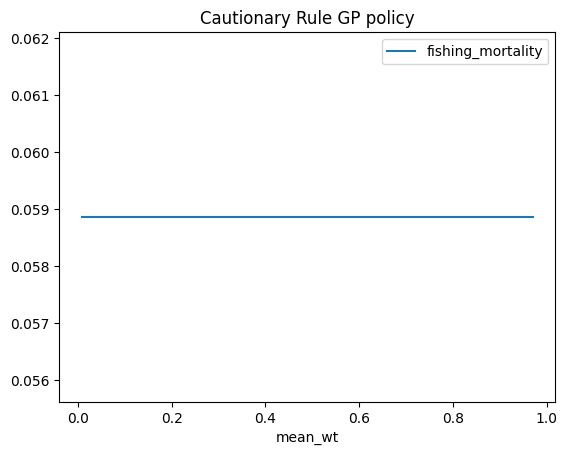

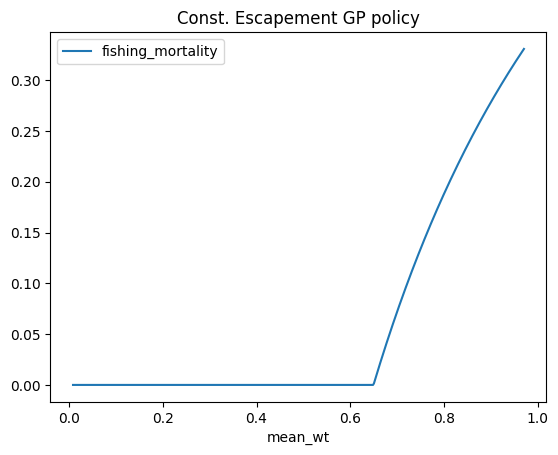

In [9]:
(
    cr_gp_df.plot(x='mean_wt', y='fishing_mortality', title='Cautionary Rule GP policy'),
    esc_gp_df.plot(x='mean_wt', y='fishing_mortality', title='Const. Escapement GP policy'),

)  

In [10]:
esc_rews = eval_pol(
    policy=ConstEsc(env=AsmEnv(config=CONFIG), observed_var='mean_wt', **esc_gp_args), 
    env_cls=AsmEnv, config=CONFIG, 
    n_batches=2, batch_size=150
)

cr_rews = eval_pol(
    policy=CautionaryRule(env=AsmEnv(config=CONFIG), observed_var='mean_wt', **cr_gp_args), 
    env_cls=AsmEnv, config=CONFIG, 
    n_batches=2, batch_size=150
)

2024-04-25 17:04:35,521	INFO worker.py:1749 -- Started a local Ray instance.
2024-04-25 17:04:42,706	INFO worker.py:1749 -- Started a local Ray instance.
2024-04-25 17:04:49,645	INFO worker.py:1749 -- Started a local Ray instance.
2024-04-25 17:04:56,672	INFO worker.py:1749 -- Started a local Ray instance.


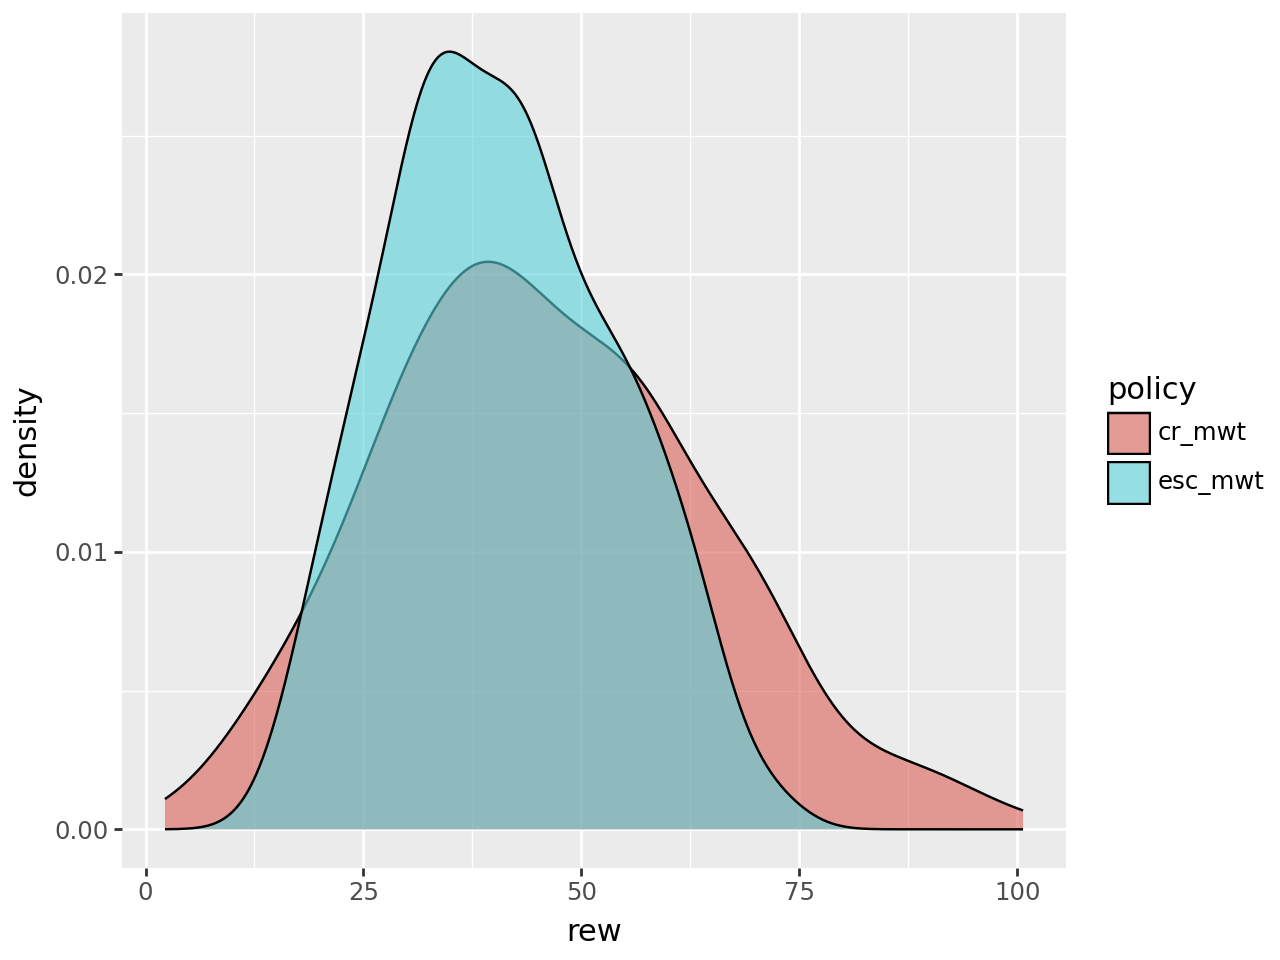

In [11]:
esc_df_mwt = pd.DataFrame({'rew': esc_rews, 'policy': ['esc_mwt' for _ in esc_rews]})
cr_df_mwt = pd.DataFrame({'rew': cr_rews, 'policy': ['cr_mwt' for _ in cr_rews]})

from plotnine import ggplot, aes, geom_density

evaluation = pd.concat([esc_df_mwt, cr_df_mwt])
ggplot(evaluation, aes(x='rew', fill='policy')) + geom_density(alpha=0.6)

## Noiseless

In [ ]:
CONFIG_NOISELESS = {
    ''
}